In [36]:
# import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import re

# import squarify

This views better on a computer instead of mobile. Some plots display extra info when hovering the mouse.

**Data restrictions:**

Expense, donation, and reimbursement data only exist for six years (2017 - 2023, minus 2020). Attendee data exists for 2014-2023. 2017 and 2021 are outliers (no charge for music and first year post-covid, respectively). We only have four years of reliable data, a ridiculously small sample size, hampering the ability to do rigorous analysis.

**Data assumptions:**

Music (2017): I conservatively added $400 for music that year, credited to Tom Brady.

Costco: I arbitrarily assigned 2/3rds to the Bar category and 1/3rd to Food.

Profit from 2023 was not donated to charity and is included in Randy Detman's reimbursements.

The above can be easily toggled / adjusted in the first section, `Data Wrangling`. The following bar adjustments would have to be made to the initial csv in the git ignored folder:

Bar (2019): I assumed Chicago's $256 was 150 12 ounce beers ($10/6-pack). Assigned "[redacted]'s liquor run" as a handle - no idea if that's accurate. I added an extra handle to Fireball for "Plus a big thing of spiked cider".

Bar (2021): Assigned 0.5 kegs each for "Parts of two kegs Two Hearted and Port City Porter". 2022 - Ignored "Plus a few wine bottles". 

Bar (2023): Assigned 8 sixtels for "About 8 sixtels Red Lager".

**In Conclusion**

Give me feedback and constructive criticism, since you can't Like, Share, and Subscribe.

## Table of Contents

- [Data Wrangling](#data-wrangling)
- [Describe the df's](#describe-the-dfs)
- [Plots!](#plots!)
- [Total Expenses and Donations](#total-expenses-and-donations)
- [Categories](#categories)
- [Reimbursements](#reimbursements)
- [Attendees](#attendees)
- [Bar](#bar)
- [Sub-categories](#sub-categories)
- [Appendix (Tables)](#appendix-(tables))

## Data Wrangling

#### Load Data Frames

#### Most data wrangling already happened, during extraction from Google Sheets, with names changed in a git ignored piece of code

## <center>df = `harvest_party_expenses.csv`</center>

In [37]:
# read in main expenses csv as a df
df = pd.read_csv("./resources/harvest_party_expenses.csv")
df.head()

Name                 Expense Expense Amt  Date bought  Category
0   Randy Detman              Key chains         150         2017     Merch
1  Morning Glory  Liquor / Food / Costco          50         2017    Costco
2   Randy Detman        Cleaning service          60         2017  Cleaning
3   Randy Detman          Carpet cleaner          50         2017  Cleaning
4  Morning Glory               Brau kegs         140         2017       Bar

In [38]:
# convert all 'Expense Amt' to float with regex (remove $ and ,)
df["Expense Amt"] = df["Expense Amt"].replace("[\$,]", "", regex=True).astype(float)

# confirm all of 'Expense Amt' are floats
df.dtypes

Name            object
Expense         object
Expense Amt    float64
Date bought      int64
Category        object
dtype: object

In [39]:
# rename columns
df = df.rename(columns={"Expense Amt": "Amount", "Date bought": "Year"})
df

Name                       Expense  Amount  Year  Category
0    Randy Detman                    Key chains   150.0  2017     Merch
1   Morning Glory        Liquor / Food / Costco    50.0  2017    Costco
2    Randy Detman              Cleaning service    60.0  2017  Cleaning
3    Randy Detman                Carpet cleaner    50.0  2017  Cleaning
4   Morning Glory                     Brau kegs   140.0  2017       Bar
..            ...                           ...     ...   ...       ...
92   Randy Detman                          Logo   200.0  2023      Logo
93         Latvia                  Sid's shirts    50.0  2023     Merch
94    Watsonville                  Cleaner Uber    20.0  2023  Cleaning
95  Bitter Barbie  New t-shirts advance payment   150.0  2023     Merch
96  Morning Glory                carpet cleaner    20.0  2023  Cleaning

[97 rows x 5 columns]

# Data Assumption!

##### Break the Costco Category up. 1/3 to Food, 2/3 to Bar.

In [40]:
# print unique values for Category
print(df["Category"].unique())
print(f"Number of unique Categories: {df['Category'].nunique()}")

['Merch' 'Costco' 'Cleaning' 'Bar' 'Food' 'Cups' 'Decoration' 'Music'
 'Porta Potty' 'Logo']
Number of unique Categories: 10


In [41]:
# Re-categorize Costco, giving 1/3 to Food, 2/3 to Bar
# food
df_food = df[df.Category == "Costco"].copy()
df_food.Amount /= 3
df_food.Category = "Food"
# bar
df_bar = df[df.Category == "Costco"].copy()
df_bar.Amount *= 2 / 3
df_bar.Category = "Bar"

# remove Costco from original df
df = df[df.Category != "Costco"]

# combine all dfs
df = pd.concat([df, df_food, df_bar], ignore_index=True)
df

Name                                            Expense  \
0     Randy Detman                                         Key chains   
1     Randy Detman                                   Cleaning service   
2     Randy Detman                                     Carpet cleaner   
3    Morning Glory                                          Brau kegs   
4        Tom Brady                                    Plates/cups etc   
..             ...                                                ...   
99   Morning Glory  Costco Liquor / Plates / Paper Towels, TP, tra...   
100   Randy Detman                                      Costco part 2   
101   Randy Detman                                             Costco   
102   Randy Detman                                             Costco   
103   Randy Detman                                             Costco   

         Amount  Year  Category  
0    150.000000  2017     Merch  
1     60.000000  2017  Cleaning  
2     50.000000  2017  Cleaning  
3    140.000000  2017       Bar  
4     50.000000  2017      Food  
..          ...   ...       ...  
99   133.333333  2019       Bar  
100   34.240000  2019       Bar  
101  178.773333  2021       Bar  
102  282.013333  2022       Bar  
103  210.306667  2023       Bar  

[104 rows x 5 columns]

In [42]:
# confirm change in unique values for Category
print(df["Category"].unique())
print(f"Number of unique Categories: {df['Category'].nunique()}")

['Merch' 'Cleaning' 'Bar' 'Food' 'Cups' 'Decoration' 'Music' 'Porta Potty'
 'Logo']
Number of unique Categories: 9


# Data Assumption!

I add on $400, to Tom Brady for Music-Bands-2017, to simulate probable costs for 2017 (there was no value for music that year, because Tom Brady is charitable).

In [43]:
df.loc[len(df.index)] = [
    "Tom Brady",
    "Bands",
    400.00,
    2017,
    "Music",
]  # toggle this line to remove assumption
df.tail()

Name        Expense      Amount  Year Category
100  Randy Detman  Costco part 2   34.240000  2019      Bar
101  Randy Detman         Costco  178.773333  2021      Bar
102  Randy Detman         Costco  282.013333  2022      Bar
103  Randy Detman         Costco  210.306667  2023      Bar
104     Tom Brady          Bands  400.000000  2017    Music

## <center>don_df = `donations.csv`</center>

In [44]:
don_df = pd.read_csv("./resources/donations.csv")
don_df

year  donations
0  2023  $5,095.00
1  2022  $5,485.00
2  2021  $1,981.00
3  2019  $3,242.40
4  2018  $1,884.00
5  2017  $1,214.00
6  2016        NaN
7  2015        NaN
8  2014        NaN

In [45]:
# convert all 'donations' to float with regex (remove $ and ,)
don_df.donations = don_df.donations.replace("[\$,]", "", regex=True).astype(float)

# confirm all of 'donations' are floats
don_df.dtypes

year           int64
donations    float64
dtype: object

In [46]:
don_df = don_df.rename(columns={"year": "Year", "donations": "Donations"})
don_df.dropna(inplace=True)
don_df

Year  Donations
0  2023     5095.0
1  2022     5485.0
2  2021     1981.0
3  2019     3242.4
4  2018     1884.0
5  2017     1214.0

## <center>reim_df = `reimbursements.csv`</center>

In [47]:
# read in pay_outs csv as a df
reim_df = pd.read_csv("./resources/reimbursements.csv")
reim_df.head()

Year           Name Paid
0  2017   Randy Detman  647
1  2017    Watsonville   40
2  2017  Morning Glory  190
3  2017      Tom Brady  337
4  2018   Randy Detman  950

In [48]:
# convert all 'Paid' to float with regex (remove $ and ,)
reim_df.Paid = reim_df.Paid.replace("[\$,]", "", regex=True).astype(float)

# confirm all of 'Paid' are floats
reim_df.dtypes

Year      int64
Name     object
Paid    float64
dtype: object

# Data Assumption!

Add 2023 profits to Randy Detman's reimbursements, as they were never donated

In [49]:
# add row to reim_df for Randy Detman, summing to the amount of df Expense in 2023 minus the amount of reim_df Paid in 2023

# sum of df Expense in 2023
df_2023 = df[df.Year == 2023].Amount.sum()
print(f"Total Expenditures in 2023: ${df_2023}")

# sum of don_df Paid in 2023
don_2023 = don_df[don_df.Year == 2023].Donations.sum()
print(f"Total Donations in 2023: ${don_2023}")
print(f"Donations minus Expenditures in 2023: ${don_2023 - df_2023:.2f}")

# add row to reim_df for Randy Detman
reim_df.loc[len(reim_df.index)] = [2023, "Randy Detman", don_2023 - df_2023]
reim_df.tail()

Total Expenditures in 2023: $4683.74
Total Donations in 2023: $5095.0
Donations minus Expenditures in 2023: $411.26


Year               Name     Paid
26  2023      Bitter Barbie  1012.05
27  2023  Burntwood Gardens   272.00
28  2023             Latvia    51.00
29  2023       Randy Detman   200.00
30  2023       Randy Detman   411.26

In [50]:
reim_df

Year               Name     Paid
0   2017       Randy Detman   647.00
1   2017        Watsonville    40.00
2   2017      Morning Glory   190.00
3   2017          Tom Brady   337.00
4   2018       Randy Detman   950.00
5   2018      Morning Glory   367.00
6   2018          Tom Brady   567.00
7   2019       Randy Detman   938.98
8   2019      Morning Glory   725.00
9   2019          Tom Brady   700.00
10  2019      Bitter Barbie   128.00
11  2019            Chicago   256.00
12  2019            Florida   106.37
13  2019  Burntwood Gardens   114.00
14  2019           Scotland    75.00
15  2019              Tarot    20.00
16  2021       Randy Detman   990.50
17  2021      Morning Glory   990.50
18  2022       Randy Detman  2002.94
19  2022      Morning Glory   566.00
20  2022          Tom Brady  1250.00
21  2022      Bitter Barbie   772.52
22  2022  Burntwood Gardens   176.74
23  2023       Randy Detman  1345.46
24  2023        Watsonville  1250.00
25  2023      Morning Glory   554.00
26  2023      Bitter Barbie  1012.05
27  2023  Burntwood Gardens   272.00
28  2023             Latvia    51.00
29  2023       Randy Detman   200.00
30  2023       Randy Detman   411.26

## <center>att_df = `attendees.csv`</center>

In [51]:
# read in attendees csv as a df
att_df = pd.read_csv("./resources/attendees.csv")
att_df

year  facebook_going  facebook_maybes
0  2023              97               29
1  2022             100               40
2  2021              95               25
3  2019             194               85
4  2018             136               54
5  2017             156               76
6  2016              59               29
7  2015             127               49
8  2014              40               11

In [52]:
att_df.dtypes

year               int64
facebook_going     int64
facebook_maybes    int64
dtype: object

In [53]:
att_df = att_df.rename(
    columns={"year": "Year", "facebook_going": "Going", "facebook_maybes": "Maybes"}
)
att_df

Year  Going  Maybes
0  2023     97      29
1  2022    100      40
2  2021     95      25
3  2019    194      85
4  2018    136      54
5  2017    156      76
6  2016     59      29
7  2015    127      49
8  2014     40      11

## <center>bar_df = `bar.csv`</center>

In [54]:
# read in bar csv as a df
alcohol_consumed_df = pd.read_csv("./resources/bar.csv")
alcohol_consumed_df.head()

Year  Quantity Packaging                      Potable
0  2018       1.0       keg             Port City Porter
1  2018       6.0    sixtel                       Kolsch
2  2018       3.0    sixtel                          IPA
3  2018       1.0    sixtel  DC Brau Wings of Armageddon
4  2018       1.5    sixtel                          ESB

In [55]:
alcohol_consumed_df.dtypes

Year           int64
Quantity     float64
Packaging     object
Potable       object
dtype: object

In [56]:
alcohol_consumed_df.Packaging.unique()

array(['keg', 'sixtel', 'handle', 'can'], dtype=object)

#### Conversion rate to extract ounces

15.5 gallons per keg = 1984 ounces

1 sixtel = 661 ounces

1 can = 12 ounces

1.75 liters per handle = 59 ounces

In [57]:
# function to add a series of ounces to df
for row in range(len(alcohol_consumed_df)):
    if alcohol_consumed_df.loc[row, "Packaging"] == "keg":
        alcohol_consumed_df.loc[row, "Ounces"] = (
            alcohol_consumed_df.loc[row, "Quantity"] * 1984
        )
    elif alcohol_consumed_df.loc[row, "Packaging"] == "sixtel":
        alcohol_consumed_df.loc[row, "Ounces"] = (
            alcohol_consumed_df.loc[row, "Quantity"] * 661
        )
    elif alcohol_consumed_df.loc[row, "Packaging"] == "handle":
        alcohol_consumed_df.loc[row, "Ounces"] = (
            alcohol_consumed_df.loc[row, "Quantity"] * 59
        )
    elif alcohol_consumed_df.loc[row, "Packaging"] == "can":
        alcohol_consumed_df.loc[row, "Ounces"] = (
            alcohol_consumed_df.loc[row, "Quantity"] * 12
        )
    else:
        raise ValueError("Packaging not recognized")

alcohol_consumed_df = alcohol_consumed_df[
    ["Year", "Quantity", "Packaging", "Ounces", "Potable"]
]

alcohol_consumed_df.head()

Year  Quantity Packaging  Ounces                      Potable
0  2018       1.0       keg  1984.0             Port City Porter
1  2018       6.0    sixtel  3966.0                       Kolsch
2  2018       3.0    sixtel  1983.0                          IPA
3  2018       1.0    sixtel   661.0  DC Brau Wings of Armageddon
4  2018       1.5    sixtel   991.5                          ESB

## <center>df_bar_expenses</center>

In [58]:
# create new df_bar_expenses where df.Category == "Bar"
df_bar_expenses = df[df["Category"] == "Bar"].reset_index(drop=True)
df_bar_expenses

Name                                            Expense  \
0   Morning Glory                                          Brau kegs   
1       Tom Brady                   Extra beer and plates from Giant   
2       Tom Brady                            Extra kegs from 3 stars   
3       Tom Brady                                               Ice    
4    Randy Detman                                           Homebrew   
5     Watsonville                                               Beer   
6   Morning Glory                            Keg of port city porter   
7   Morning Glory                                   Liquor at Costco   
8    Randy Detman                     FBC Kegs (8 @ roughly $45/keg)   
9   Morning Glory          Tonic Kegs (Port City Porter & Bold Rock)   
10   Randy Detman                                           Homebrew   
11  Bitter Barbie                                                Ice   
12        Chicago                                           Beer run   
13      Tom Brady                                         Liquor run   
14       Scotland                                         Liquor run   
15        Florida                                          Giant run   
16  Morning Glory                                         Tonic Kegs   
17  Morning Glory                                            Keg tax   
18   Randy Detman                                      Fishbowl Beer   
19   Randy Detman                                     Keg Taps/Lines   
20   Randy Detman                                        CO2/propane   
21   Randy Detman                                Giant - Ice, mixers   
22   Randy Detman                             Shell Gas Station- Ice   
23  Morning Glory                                       Giant Mixers   
24  Morning Glory                   Lime juice, cider and sign stuff   
25  Morning Glory                                         Tonic kegs   
26  Bitter Barbie                                           Ice bags   
27   Randy Detman                         Beer ($65/Keg) + CO2 ($50)   
28  Morning Glory                                     Mixers / Cider   
29  Morning Glory                                         Tonic kegs   
30   Randy Detman                         Beer ($70/Keg) + CO2 ($50)   
31  Morning Glory                             Liquor / Food / Costco   
32   Randy Detman                                             Costco   
33  Morning Glory  Costco Liquor / Plates / Paper Towels, TP, tra...   
34   Randy Detman                                      Costco part 2   
35   Randy Detman                                             Costco   
36   Randy Detman                                             Costco   
37   Randy Detman                                             Costco   

        Amount  Year Category  
0   140.000000  2017      Bar  
1    50.000000  2017      Bar  
2   137.000000  2017      Bar  
3    60.000000  2017      Bar  
4   130.000000  2017      Bar  
5    40.000000  2017      Bar  
6   154.000000  2018      Bar  
7   135.000000  2018      Bar  
8   360.000000  2018      Bar  
9   310.000000  2019      Bar  
10  400.000000  2019      Bar  
11  128.000000  2019      Bar  
12  256.000000  2019      Bar  
13  100.000000  2019      Bar  
14   75.000000  2019      Bar  
15  106.370000  2019      Bar  
16  623.000000  2021      Bar  
17   74.300000  2021      Bar  
18   40.000000  2021      Bar  
19   50.000000  2021      Bar  
20   40.000000  2021      Bar  
21   94.330000  2021      Bar  
22   35.000000  2021      Bar  
23   70.750000  2021      Bar  
24   83.000000  2022      Bar  
25  333.000000  2022      Bar  
26   96.000000  2022      Bar  
27  700.000000  2022      Bar  
28   68.230000  2023      Bar  
29  316.000000  2023      Bar  
30  820.000000  2023      Bar  
31   33.333333  2017      Bar  
32  137.333333  2017      Bar  
33  133.333333  2019      Bar  
34   34.240000  2019      Bar  
35  178.773333  2021      Bar  
36  282.013333  2022

In [59]:
# add series to subcategorize df into beer and liquor

# use regex to sort beer and liquor
def assign_type(expense):
    if any(re.search(r'\b(beer|keg|kegs|homebrew|ice)\b', expense, re.IGNORECASE) for word in expense.split()):
        return "Beer"
    elif any(re.search(r'\b(liquor|Costco|mixers|cider\b)', expense, re.IGNORECASE) for word in expense.split()):
        return "Liquor"
    else:
        return "Other"
    
df_bar_expenses["Type"] = df_bar_expenses.Expense.apply(assign_type)

df_bar_expenses.head()

Name                           Expense  Amount  Year Category  \
0  Morning Glory                         Brau kegs   140.0  2017      Bar   
1      Tom Brady  Extra beer and plates from Giant    50.0  2017      Bar   
2      Tom Brady           Extra kegs from 3 stars   137.0  2017      Bar   
3      Tom Brady                              Ice     60.0  2017      Bar   
4   Randy Detman                          Homebrew   130.0  2017      Bar   

   Type  
0  Beer  
1  Beer  
2  Beer  
3  Beer  
4  Beer

In [60]:
# print rows where Type == "Other"
df_bar_expenses[df_bar_expenses.Type == "Other"]

Name      Expense  Amount  Year Category   Type
15       Florida    Giant run  106.37  2019      Bar  Other
20  Randy Detman  CO2/propane   40.00  2021      Bar  Other

In [61]:
# swtich "Other" to "Beer"
df_bar_expenses.Type = df_bar_expenses.Type.replace("Other", "Beer")

df_bar_expenses

Name                                            Expense  \
0   Morning Glory                                          Brau kegs   
1       Tom Brady                   Extra beer and plates from Giant   
2       Tom Brady                            Extra kegs from 3 stars   
3       Tom Brady                                               Ice    
4    Randy Detman                                           Homebrew   
5     Watsonville                                               Beer   
6   Morning Glory                            Keg of port city porter   
7   Morning Glory                                   Liquor at Costco   
8    Randy Detman                     FBC Kegs (8 @ roughly $45/keg)   
9   Morning Glory          Tonic Kegs (Port City Porter & Bold Rock)   
10   Randy Detman                                           Homebrew   
11  Bitter Barbie                                                Ice   
12        Chicago                                           Beer run   
13      Tom Brady                                         Liquor run   
14       Scotland                                         Liquor run   
15        Florida                                          Giant run   
16  Morning Glory                                         Tonic Kegs   
17  Morning Glory                                            Keg tax   
18   Randy Detman                                      Fishbowl Beer   
19   Randy Detman                                     Keg Taps/Lines   
20   Randy Detman                                        CO2/propane   
21   Randy Detman                                Giant - Ice, mixers   
22   Randy Detman                             Shell Gas Station- Ice   
23  Morning Glory                                       Giant Mixers   
24  Morning Glory                   Lime juice, cider and sign stuff   
25  Morning Glory                                         Tonic kegs   
26  Bitter Barbie                                           Ice bags   
27   Randy Detman                         Beer ($65/Keg) + CO2 ($50)   
28  Morning Glory                                     Mixers / Cider   
29  Morning Glory                                         Tonic kegs   
30   Randy Detman                         Beer ($70/Keg) + CO2 ($50)   
31  Morning Glory                             Liquor / Food / Costco   
32   Randy Detman                                             Costco   
33  Morning Glory  Costco Liquor / Plates / Paper Towels, TP, tra...   
34   Randy Detman                                      Costco part 2   
35   Randy Detman                                             Costco   
36   Randy Detman                                             Costco   
37   Randy Detman                                             Costco   

        Amount  Year Category    Type  
0   140.000000  2017      Bar    Beer  
1    50.000000  2017      Bar    Beer  
2   137.000000  2017      Bar    Beer  
3    60.000000  2017      Bar    Beer  
4   130.000000  2017      Bar    Beer  
5    40.000000  2017      Bar    Beer  
6   154.000000  2018      Bar    Beer  
7   135.000000  2018      Bar  Liquor  
8   360.000000  2018      Bar    Beer  
9   310.000000  2019      Bar    Beer  
10  400.000000  2019      Bar    Beer  
11  128.000000  2019      Bar    Beer  
12  256.000000  2019      Bar    Beer  
13  100.000000  2019      Bar  Liquor  
14   75.000000  2019      Bar  Liquor  
15  106.370000  2019      Bar    Beer  
16  623.000000  2021      Bar    Beer  
17   74.300000  2021      Bar    Beer  
18   40.000000  2021      Bar    Beer  
19   50.000000  2021      Bar    Beer  
20   40.000000  2021      Bar    Beer  
21   94.330000  2021      Bar    Beer  
22   35.000000  2021      Bar    Beer  
23   70.750000  2021      Bar  Liquor  
24   83.000000  2022      Bar  Liquor  
25  333.000000  2022      Bar    Beer  
26   96.000000  2022      Bar    Beer  
27  700.000000  2022      Bar    Beer  
28   68.230000  2023      Bar  Liquor  
29  

#### Data wrangling complete

#### ------------

## Describe the dfs

Basic stats. Count of rows / entries. Mean (average), max and min, standard deviation, quartiles. Ignore the Year column.

- [Back to Table of Contents](#table-of-contents)

In [62]:
df.describe(include="all")  # expenses

Name Expense      Amount         Year Category
count            105     105  105.000000   105.000000      105
unique            11      76         NaN          NaN        9
top     Randy Detman  Costco         NaN          NaN      Bar
freq              45       9         NaN          NaN       38
mean             NaN     NaN  181.156571  2020.219048      NaN
std              NaN     NaN  201.362918     2.183773      NaN
min              NaN     NaN    0.000000  2017.000000      NaN
25%              NaN     NaN   60.000000  2018.000000      NaN
50%              NaN     NaN  106.370000  2021.000000      NaN
75%              NaN     NaN  200.000000  2022.000000      NaN
max              NaN     NaN  950.000000  2023.000000      NaN

In [63]:
reim_df.describe(include="all")  # reimbursements

Year          Name         Paid
count     31.000000            31    31.000000
unique          NaN            11          NaN
top             NaN  Randy Detman          NaN
freq            NaN             8          NaN
mean    2020.290323           NaN   580.849032
std        2.224014           NaN   481.443641
min     2017.000000           NaN    20.000000
25%     2019.000000           NaN   183.370000
50%     2019.000000           NaN   554.000000
75%     2022.500000           NaN   944.490000
max     2023.000000           NaN  2002.940000

In [64]:
don_df.describe(include="all")  # donations

Year    Donations
count     6.000000     6.000000
mean   2020.000000  3150.233333
std       2.366432  1786.684104
min    2017.000000  1214.000000
25%    2018.250000  1908.250000
50%    2020.000000  2611.700000
75%    2021.750000  4631.850000
max    2023.000000  5485.000000

In [65]:
att_df.describe(include="all")  # attendees

Year       Going     Maybes
count     9.000000    9.000000   9.000000
mean   2018.333333  111.555556  44.222222
std       3.162278   47.579174  24.355583
min    2014.000000   40.000000  11.000000
25%    2016.000000   95.000000  29.000000
50%    2018.000000  100.000000  40.000000
75%    2021.000000  136.000000  54.000000
max    2023.000000  194.000000  85.000000

## Plots!

## Total Expenses and Donations

- [Back to Table of Contents](#table-of-contents)

In [66]:
print("INTRODUCTORY SUMMARY STATS!")
print("-------------------------------------")
print(f"Total Spent over all years: ${df.Amount.sum():.2f}")
print(f"Total Donations over all years: ${don_df.Donations.sum():.2f}")
print(f"Total Reimbursed over all years: ${reim_df.Paid.sum():.2f}\n")
print(
    f"Total hypothetical profit over all years: ${don_df.Donations.sum() - df.Amount.sum():.2f}"
)
print(
    f"Total actual profit over all years: ${don_df.Donations.sum() - reim_df.Paid.sum():.2f}\n"
)
print(
    """N.B. (February 2024): We donated 2022, $716.80, to Capital Area Food Bank.
We did not donate 2023 ($411.26) or 2019 ($179.05)."""
)
print(
    "We were surprised when we turned a profit in 2019. I think we threw a pizza party.\n"
)

# group by year, calculate total expenses and donations per year
df_yearly = df.groupby("Year")["Amount"].sum()
don_yearly = don_df.groupby("Year")["Donations"].sum()

# calculate profit per year
profit_yearly = don_yearly - df_yearly

# sum years with positive and negative profit
positive_profit_sum = profit_yearly[profit_yearly > 0].round(2).sum()
negative_profit_sum = profit_yearly[profit_yearly < 0].sum()

# Print the results
print(f"Sum of years with positive profit: ${positive_profit_sum:.2f}")
print(f"Sum of years with negative profit: ${negative_profit_sum:.2f}\n")
print("Numbers slightly off due to rounding errors (floating point imprecision)")

INTRODUCTORY SUMMARY STATS!
-------------------------------------
Total Spent over all years: $19021.44
Total Donations over all years: $18901.40
Total Reimbursed over all years: $18006.32

Total hypothetical profit over all years: $-120.04
Total actual profit over all years: $895.08

N.B. (February 2024): We donated 2022, $716.80, to Capital Area Food Bank.
We did not donate 2023 ($411.26) or 2019 ($179.05).
We were surprised when we turned a profit in 2019. I think we threw a pizza party.

Sum of years with positive profit: $1307.11
Sum of years with negative profit: $-1427.15

Numbers slightly off due to rounding errors (floating point imprecision)


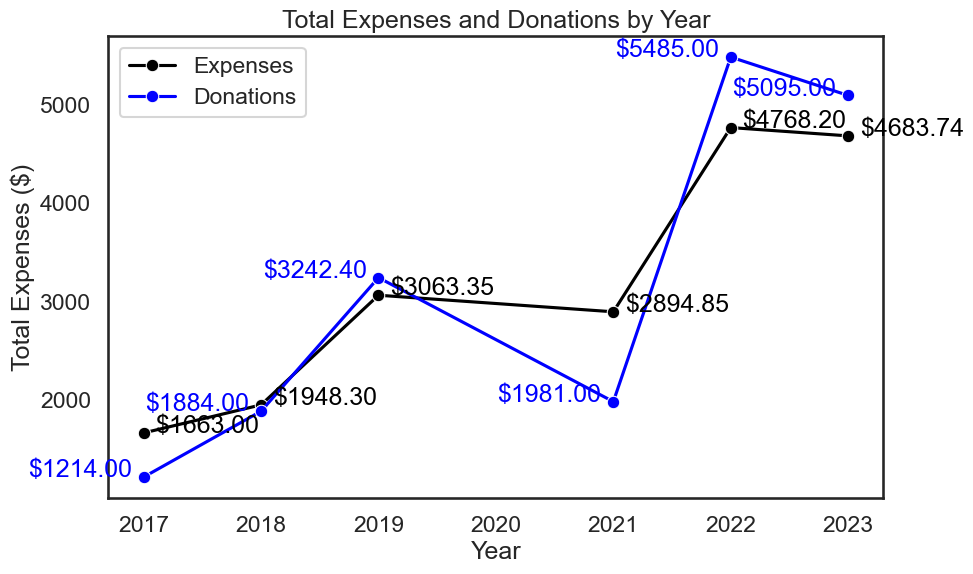

In [67]:
# plot expenses and donations by year as a line chart
sns.set_theme(style="white", context="talk")
plt.figure(figsize=(10, 6))
sns.lineplot(
    x="Year",
    y="Amount",
    data=df,
    estimator="sum",
    errorbar=None,
    marker="o",
    color="black",
)
sns.lineplot(
    x="Year", y="Donations", data=don_df, errorbar=None, marker="o", color="blue"
)

# annotate each data point
df_sum = df.groupby("Year")["Amount"].sum()
for year, amount in df_sum.items():
    plt.text(
        year + 0.1, amount, f"${amount:.2f}", horizontalalignment="left", color="black"
    )
for _, row in don_df.iterrows():
    year = row.Year
    amount = row.Donations
    plt.text(
        year - 0.1, amount, f"${amount:.2f}", horizontalalignment="right", color="blue"
    )

# format plot
plt.title("Total Expenses and Donations by Year")
plt.xlabel("Year")
plt.ylabel("Total Expenses ($)")
plt.legend(["Expenses", "Donations"])
plt.show()

No surprises here. 2021 was bad, all other years were marginal misses or actually turned a profit. 2017 is definitely off, as there is no charge for music, so we probably lost quite a bit of money that year. I'm suspicious about 2018 as well. Tom Brady is generous (and giggling to themselves at all of the kudos I shall be giving to "Tom Brady" who, to be clear, is not the famous ball-deflating footballer, but a pseudonym for a dear friend and hapless Tom Brady fan).

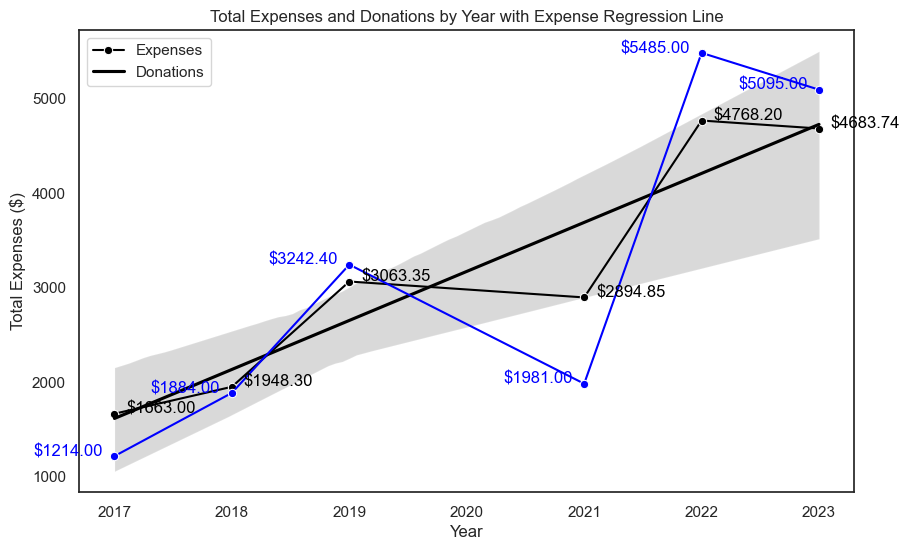

In [68]:
# plot expenses and donations by year as a line chart
sns.set_theme(style="white")
plt.figure(figsize=(10, 6))
sns.lineplot(
    x="Year",
    y="Amount",
    data=df,
    estimator="sum",
    errorbar=None,
    marker="o",
    color="black",
)

# create a new DataFrame that contains the sum of expenses for each year
df_sum = df.groupby("Year")["Amount"].sum().reset_index()

# add a regression line for the sum of expenses per year
sns.regplot(x="Year", y="Amount", data=df_sum, scatter=False, color="black")

sns.lineplot(
    x="Year", y="Donations", data=don_df, errorbar=None, marker="o", color="blue"
)

# annotate each data point
for _, row in df_sum.iterrows():  # iterate over rows of df_sum
    year = row.Year
    amount = row.Amount
    plt.text(
        year + 0.1, amount, f"${amount:.2f}", horizontalalignment="left", color="black"
    )
for _, row in don_df.iterrows():
    year = row.Year
    amount = row.Donations
    plt.text(
        year - 0.1, amount, f"${amount:.2f}", horizontalalignment="right", color="blue"
    )

# format plot
plt.title("Total Expenses and Donations by Year with Expense Regression Line")
plt.xlabel("Year")
plt.ylabel("Total Expenses ($)")
plt.legend(["Expenses", "Donations"])
plt.show()

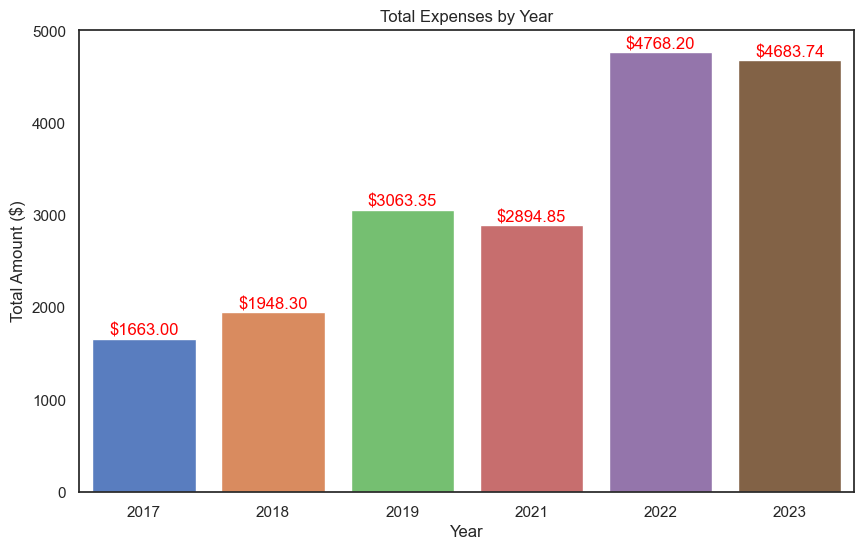

In [69]:
# bar plot of each year's expenses

# group and sort sums by year
df_sum = df.groupby("Year")["Amount"].sum().reset_index()
df_sum = df_sum.sort_values("Amount", ascending=False)

# plot the chart
sns.set_theme(style="white")
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="Year", y="Amount", data=df_sum, palette="muted")

# add labels
for container in ax.containers:
    ax.bar_label(container, fmt="$%.2f", color="red")

# format plot
plt.title("Total Expenses by Year")
plt.xlabel("Year")
plt.ylabel("Total Amount ($)")
plt.show()

Before: 
   Year  Expenses  Donations
0  2017   1663.00     1214.0
1  2018   1948.30     1884.0
2  2019   3063.35     3242.4
3  2021   2894.85     1981.0
4  2022   4768.20     5485.0
5  2023   4683.74     5095.0

After: 
    Year       Type   Amount
0   2017   Expenses  1663.00
1   2018   Expenses  1948.30
2   2019   Expenses  3063.35
3   2021   Expenses  2894.85
4   2022   Expenses  4768.20
5   2023   Expenses  4683.74
6   2017  Donations  1214.00
7   2018  Donations  1884.00
8   2019  Donations  3242.40
9   2021  Donations  1981.00
10  2022  Donations  5485.00
11  2023  Donations  5095.00


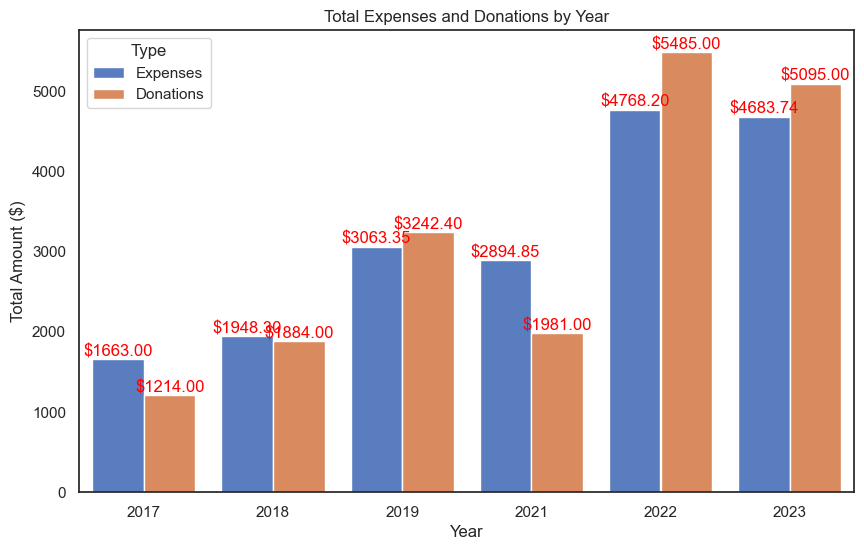

In [70]:
# grouped barchart of expenses and donations by year
df_sum = df.groupby("Year")["Amount"].sum().reset_index()
df_sum.columns = ["Year", "Expenses"]

don_sum = don_df.copy()

# merge expenses and donations dfs
df_sum = pd.merge(df_sum, don_sum, on="Year", how="outer")

# 'unpivot' the df (see print() output for before and after)
print(f"Before: \n{df_sum}\n")
df_sum_melt = df_sum.melt("Year", var_name="Type", value_name="Amount")
print(f"After: \n{df_sum_melt}")

# plot grouped barchart
sns.set_theme(style="white")
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="Year", y="Amount", hue="Type", data=df_sum_melt, palette="muted")

# add labels
for container in ax.containers:
    ax.bar_label(container, fmt="$%.2f", color="red")

# format plot
plt.title("Total Expenses and Donations by Year")
plt.xlabel("Year")
plt.ylabel("Total Amount ($)")
plt.legend(title="Type")
plt.show()

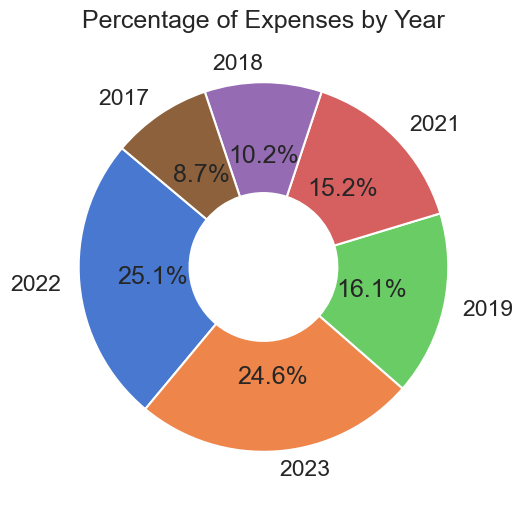

In [71]:
# plot total expenses by year as a donut chart

# group and sort sums by year
df_sum = df.groupby("Year")["Amount"].sum().reset_index()
df_sum = df_sum.sort_values("Amount", ascending=False)

# plot and format donut chart
sns.set_theme(style="white", context="talk")
plt.figure(figsize=(10, 6))
plt.pie(
    df_sum.Amount,
    labels=df_sum.Year,
    autopct="%1.1f%%",
    startangle=140,
    colors=sns.color_palette("muted"),
    wedgeprops=dict(width=0.6, edgecolor="w"),
)
plt.title("Percentage of Expenses by Year")
plt.show()

2022 and 2023 took up half of all expenses for the six years we have data. Costs have escalated. This is a central, albeit unsurprising, insight.

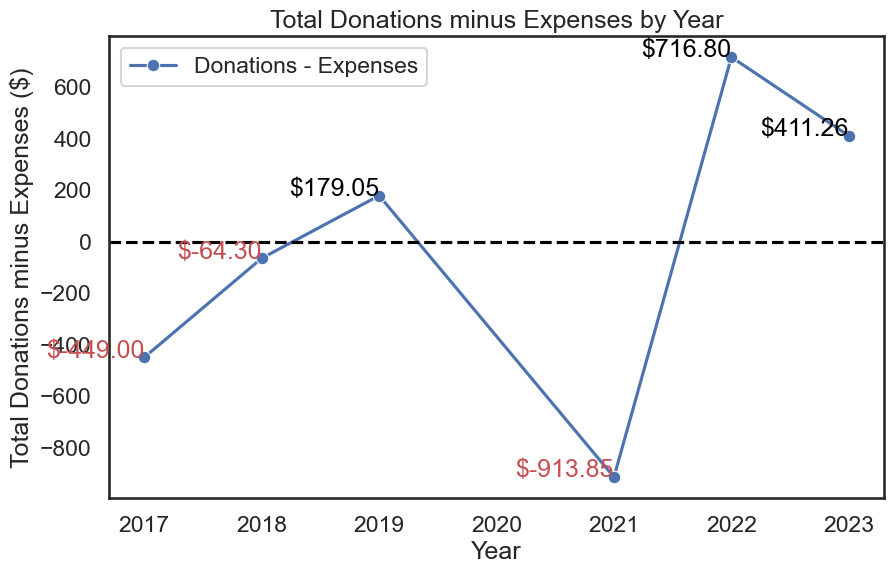

In [72]:
# plot donations minus expenses by year as a line chart

# group and sum expenses by year
df_sum = df.groupby("Year")["Amount"].sum().reset_index()
df_sum.columns = ["Year", "Amount"]

don_sum = don_df.copy()  # donations df

# merge expenses and donations dfs
df_sum = pd.merge(df_sum, don_sum, on="Year", how="outer")

# calculate expenses minus donations
df_sum["Donations_minus_expenses"] = df_sum["Donations"] - df_sum["Amount"]

# plot and format line chart
sns.set_theme(style="white", context="talk")
plt.figure(figsize=(10, 6))

sns.lineplot(
    x="Year",
    y="Donations_minus_expenses",
    data=df_sum,
    marker="o",
    # color="r",
    label="Donations - Expenses",
)

# Add a horizontal line at y=0
plt.axhline(0, color="black", linestyle="--")

# annotate each data point
for _, row in df_sum.iterrows():
    year = row.Year
    amount = row.Donations_minus_expenses
    color = "r" if amount < 0 else "black"
    plt.text(year, amount, f"${amount:.2f}", horizontalalignment="right", color=color)

# format plot
plt.title("Total Donations minus Expenses by Year")
plt.xlabel("Year")
plt.ylabel("Total Donations minus Expenses ($)")
plt.show()

## Categories

- [Back to Table of Contents](#table-of-contents)

<Figure size 1000x600 with 0 Axes>

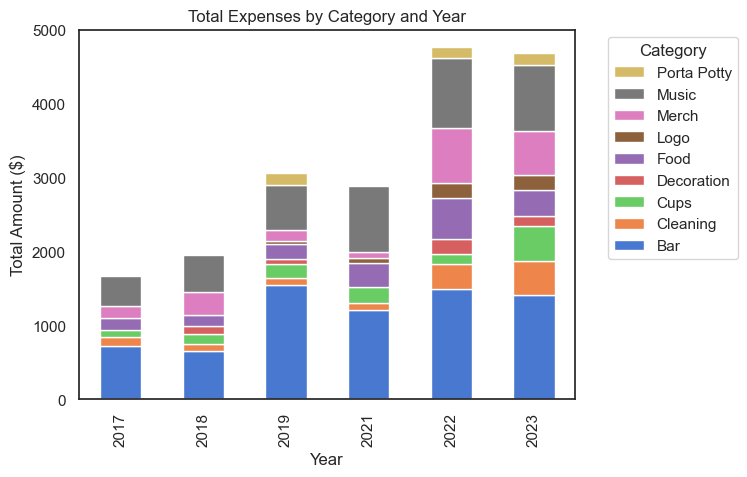

In [73]:
# plot a grouped bar chart of expenses by category, per year
df_cat = df.groupby(["Year", "Category"])["Amount"].sum().reset_index()
df_cat = df_cat.pivot(index="Year", columns="Category", values="Amount").reset_index()
df_cat = df_cat.fillna(0)

# plot the chart
sns.set_theme(style="white")
plt.figure(figsize=(10, 6))
ax = df_cat.plot(x="Year", kind="bar", stacked=True, color=sns.color_palette("muted"))

# format plot
plt.title("Total Expenses by Category and Year")
plt.xlabel("Year")
plt.ylabel("Total Amount ($)")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc="upper left", reverse=True)
plt.show()

<Figure size 1000x600 with 0 Axes>

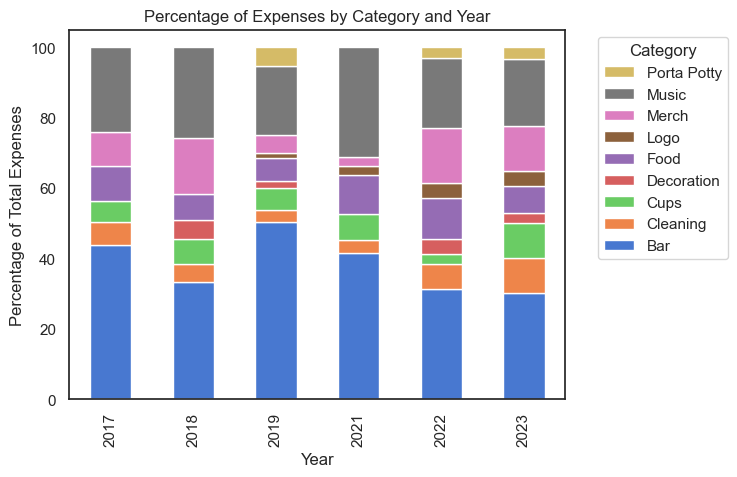

In [74]:
# plot of percentage of expenses by category per year

# group and sort sums by Category and Year
df_cat_year_sum = df.groupby(["Category", "Year"]).sum().reset_index()

# calculate total expenses per year
total_expenses_per_year = df.groupby("Year")["Amount"].sum().reset_index()

# merge total expenses into df_cat_year_sum
df_cat_year_sum = pd.merge(
    df_cat_year_sum, total_expenses_per_year, on="Year", suffixes=("", "_total")
)

# calculate percentage for each category-year combination
df_cat_year_sum["Percentage"] = (
    df_cat_year_sum["Amount"] / df_cat_year_sum["Amount_total"]
) * 100

# pivot df so each Category is a column for plotting
df_pivot = df_cat_year_sum.pivot(
    index="Year", columns="Category", values="Percentage"
).reset_index()
df_pivot = df_pivot.fillna(0)

# plot the chart
sns.set_theme(style="white")
plt.figure(figsize=(10, 6))
ax = df_pivot.plot(x="Year", kind="bar", stacked=True, color=sns.color_palette("muted"))

# format plot
plt.title("Percentage of Expenses by Category and Year")
plt.xlabel("Year")
plt.ylabel("Percentage of Total Expenses")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc="upper left", reverse=True)
plt.show()

In [75]:
# plot of percentage of expenses by category per year (fancy)

# group and sort sums by Category and Year
df_cat_year_sum = df.groupby(["Category", "Year"]).sum().reset_index()

# calculate total expenses per year
total_expenses_per_year = df.groupby("Year")["Amount"].sum().reset_index()

# merge total expenses into df_cat_year_sum
df_cat_year_sum = pd.merge(
    df_cat_year_sum, total_expenses_per_year, on="Year", suffixes=("", "_total")
)

# calculate percentage for each category-year combination
df_cat_year_sum["Percentage"] = (
    df_cat_year_sum["Amount"] / df_cat_year_sum["Amount_total"]
) * 100

# plot the chart
fig = px.bar(
    df_cat_year_sum,
    x="Year",
    y="Percentage",
    color="Category",
    labels={"Percentage": "Percentage of Total Expenses", "Year": "Year"},
    title="Percentage of Expenses by Category and Year (Hover for more info)",
    hover_data=["Category", "Percentage"],
    category_orders={"Category": sorted(df["Category"].unique())},
    custom_data=["Category", "Amount"],
)

# set the legend order
fig.update_layout(legend=dict(title="Category", traceorder="reversed"))

# format percentage and display the category in the hover
fig.update_traces(
    hovertemplate="Category: %{customdata[0]}<br>Percentage: %{y:.2f}%<br>Amount: $%{customdata[1]:.2f}"
)

fig.show()

2017 and 2021 are outliers. Why was 2019 so different from 2018, 2022, and 2023? My guess is, it was the best attended of them all, so we had to purchase extra alcohol the day of the party (at usurious rates).

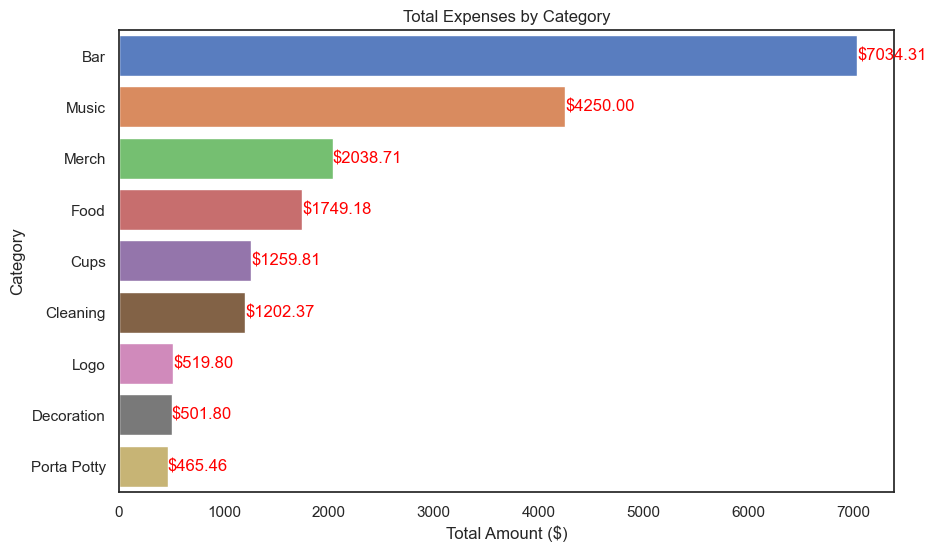

In [76]:
# plot a bar chart of total expenses by category

# group and sort Amount by Category
df_cat_sum = df.groupby("Category")["Amount"].sum().reset_index()
df_cat_sum = df_cat_sum.sort_values("Amount", ascending=False)

# plot the chart
sns.set_theme(style="white")
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="Amount", y="Category", data=df_cat_sum, palette="muted")

# add labels
for container in ax.containers:
    ax.bar_label(container, fmt="$%.2f", color="red")

# format plot
plt.title("Total Expenses by Category")
plt.xlabel("Total Amount ($)")
plt.ylabel("Category")
plt.show()

Bar and Music are our greatest contributors to cost. Also, kinda fixed costs. We should investigate ways to cheapen these expenses, but I suspect we can only shave off a little bit.

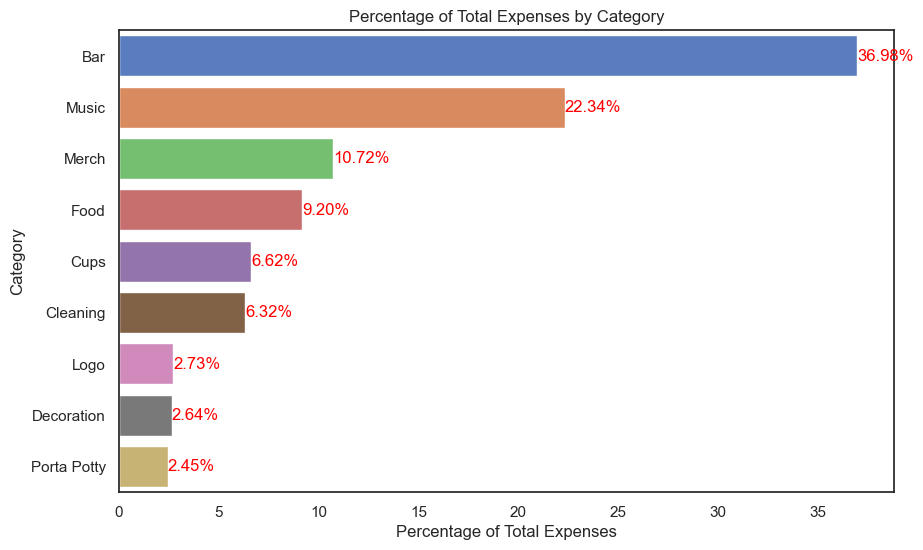

In [77]:
# bar chart of total expenses by category as a percentage of total expenses

# group and sort Amount by Category
df_cat_sum = df.groupby("Category")["Amount"].sum().reset_index()
df_cat_sum = df_cat_sum.sort_values("Amount", ascending=False)

# calculate percentage of total expenses for each category
df_cat_sum["Percentage"] = (df_cat_sum["Amount"] / df_cat_sum["Amount"].sum()) * 100

# plot the chart
sns.set_theme(style="white")
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="Percentage", y="Category", data=df_cat_sum, palette="muted")


# label foramtter
def format_label(value):
    return f"{value:.2f}%"


# add labels
for container in ax.containers:
    ax.bar_label(container, fmt=format_label, color="red")

# format plot
plt.title("Percentage of Total Expenses by Category")
plt.xlabel("Percentage of Total Expenses")
plt.ylabel("Category")
plt.show()

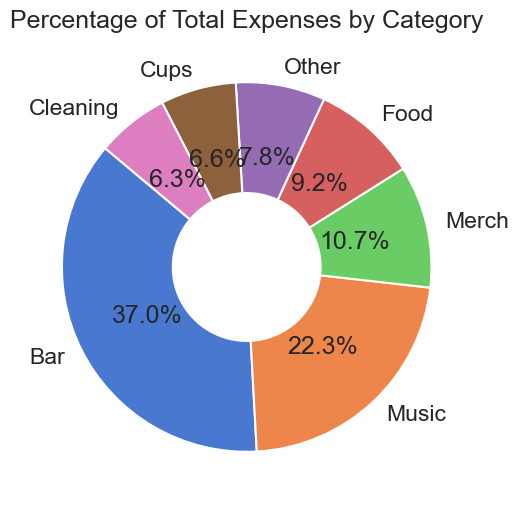

In [78]:
# pie chart of total expenses by category as a percentage of total expenses

# group and sort Amount by Category
df_cat_sum = df.groupby("Category")["Amount"].sum().reset_index()
df_cat_sum = df_cat_sum.sort_values("Amount", ascending=False)

# calculate percentage of total expenses for each category
df_cat_sum["Percentage"] = (df_cat_sum["Amount"] / df_cat_sum["Amount"].sum()) * 100

# replace names of those with less than 5% of the total with 'Other'
df_cat_sum.loc[df_cat_sum.Percentage < 5, "Category"] = "Other"

# group by name again to combine all 'Other' rows
df_cat_sum = df_cat_sum.groupby("Category").sum().reset_index()

# sort df
df_cat_sum = df_cat_sum.sort_values("Percentage", ascending=False)

# plot and format pie chart
sns.set_theme(style="white", context="talk")
plt.figure(figsize=(10, 6))
plt.pie(
    df_cat_sum.Percentage,
    labels=df_cat_sum.Category,
    autopct="%1.1f%%",
    startangle=140,
    colors=sns.color_palette("muted"),
    wedgeprops=dict(width=0.6, edgecolor="w"),
)
plt.title("Percentage of Total Expenses by Category")
plt.show()

In [79]:
# # treemap of total expenses by category

# # group and sort sums by category
# df_cat_sum = df.groupby("Category")["Amount"].sum().reset_index()
# df_cat_sum = df_cat_sum.sort_values("Amount", ascending=False)

# # plot chart
# fig = px.treemap(df_cat_sum, path=['Category'], values='Amount',
#                  title='Total Expenses by Category')

# # update layout for better display
# fig.update_layout(
#     height=600,
#     width=800,
#     uniformtext=dict(minsize=12, mode='hide'),
# )

# fig.show()

In [80]:
# # alternate treemap with percentages

# # group and sort sums by category
# df_cat_sum = df.groupby("Category")["Amount"].sum().reset_index()
# df_cat_sum = df_cat_sum.sort_values("Amount", ascending=False)

# # calculate percentage
# total = df_cat_sum["Amount"].sum()
# df_cat_sum["Percentage"] = df_cat_sum["Amount"].apply(lambda x: x / total * 100)

# # labels with percentage
# df_cat_sum["Label"] = df_cat_sum["Category"] + " (" + df_cat_sum["Percentage"].round(2).astype(str) + "%)"

# # plot chart
# fig = px.treemap(df_cat_sum, path=['Label'], values='Amount',
#                  title='Total Expenses by Category')

# # update layout for better display
# fig.update_layout(
#     height=600,
#     width=800,
#     uniformtext=dict(minsize=12, mode='hide'),
# )

# fig.show()

In [81]:
# # alternate treemap using squarify

# # group and sort sums by category
# df_cat_sum = df.groupby("Category")["Amount"].sum().reset_index()
# df_cat_sum = df_cat_sum.sort_values("Amount", ascending=False)

# # calculate relative sizes of rectangles
# sizes = df_cat_sum["Amount"] / df_cat_sum["Amount"].sum()

# # plot chart
# sns.set_theme(style="white")
# plt.figure(figsize=(10, 6))
# squarify.plot(sizes=sizes, label=df_cat_sum["Category"], alpha=0.6)

# # format plot
# plt.title("Total Expenses by Category")
# plt.axis('off')  # Turn off the axis
# plt.show()

In [82]:
# treemap of expenses by category and year

# group and sort sums by Category and Year
df_cat_year_sum = df.groupby(["Category", "Year"]).sum().reset_index()

# calculate percentage of total expenses for each category-year combination
df_cat_year_sum["Percentage"] = df_cat_year_sum.groupby("Year")["Amount"].transform(
    lambda x: x / x.sum() * 100
)

# plot the chart
fig = px.treemap(
    df_cat_year_sum,
    path=["Year", "Category"],
    values="Percentage",
    color="Year",
    color_continuous_scale="Viridis",
    title="Treemap Chart of Expenses by Category and Year (Hover for more info)",
    custom_data=["Percentage", "Amount"],
)

# update layout for better display
fig.update_layout(
    height=600,
    width=800,
    uniformtext=dict(minsize=12, mode="hide"),
)

# format percentage
fig.update_traces(
    hovertemplate="Year: %{parent}<br>Category: %{label}<br>Percentage: %{customdata[0]:.2f}%<br>Amount: $%{customdata[1]:.2f}"
)

fig.show()

Click 'View as a scrollable element' to see the before and after of the pivot

Before: 
    Year     Category       Amount
0   2017          Bar   727.666667
1   2017     Cleaning   110.000000
2   2017         Cups   100.000000
3   2017         Food   165.333333
4   2017        Merch   160.000000
5   2017        Music   400.000000
6   2018          Bar   649.000000
7   2018     Cleaning   100.000000
8   2018         Cups   140.580000
9   2018   Decoration   100.000000
10  2018         Food   145.000000
11  2018        Merch   313.720000
12  2018        Music   500.000000
13  2019          Bar  1542.943333
14  2019     Cleaning   100.000000
15  2019         Cups   195.520000
16  2019   Decoration    60.000000
17  2019         Food   197.786667
18  2019         Logo    45.000000
19  2019        Merch   156.640000
20  2019        Music   600.000000
21  2019  Porta Potty   165.460000
22  2021          Bar  1206.153333
23  2021     Cleaning   100.000000
24  2021         Cups   214.120000
25

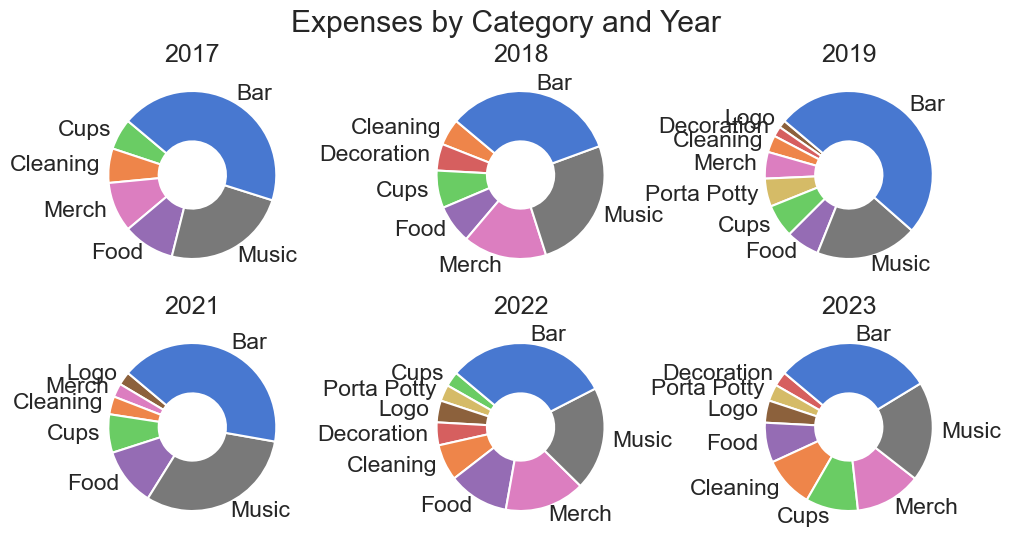

In [83]:
# plot every year's expenses by category as a donut chart

# group and sort sums by year
df_cat = df.groupby(["Year", "Category"])["Amount"].sum().reset_index()
print("Click 'View as a scrollable element' to see the before and after of the pivot\n")
print(f"Before: \n{df_cat}\n")
# pivot df so each Category is a column - before & after below (click view as a scrollable element)
df_cat = df_cat.pivot(index="Year", columns="Category", values="Amount").reset_index()
df_cat = df_cat.fillna(0)
print(f"After: \n{df_cat}")

# color dict, to ensure colors remain the same
categories = df_cat.columns[1:]
palette = sns.color_palette("muted", n_colors=len(categories))
color_dict = dict(zip(categories, palette))

# format overall figure
sns.set_theme(style="white", context="talk")
plt.figure(figsize=(12, 6))

for i, year in enumerate(df_cat.Year):
    # create a new subplot for each year
    plt.subplot(2, 3, i + 1)
    # Get values and labels, and filter out values that are zero
    values = df_cat.iloc[i, 1:]
    labels = df_cat.columns[1:]
    values, labels = values[values != 0], labels[values != 0]

    # sort values and labels
    labels = labels[values.argsort()]
    values = np.sort(values)

    # get colors
    colors = [color_dict[label] for label in labels]

    # plot the donut chart with filtered values and labels
    plt.pie(
        values,
        labels=labels,
        startangle=140,
        colors=colors,
        wedgeprops=dict(width=0.6, edgecolor="w"),
    )
    plt.title(year)

# format overall figure
plt.suptitle("Expenses by Category and Year")
plt.show()

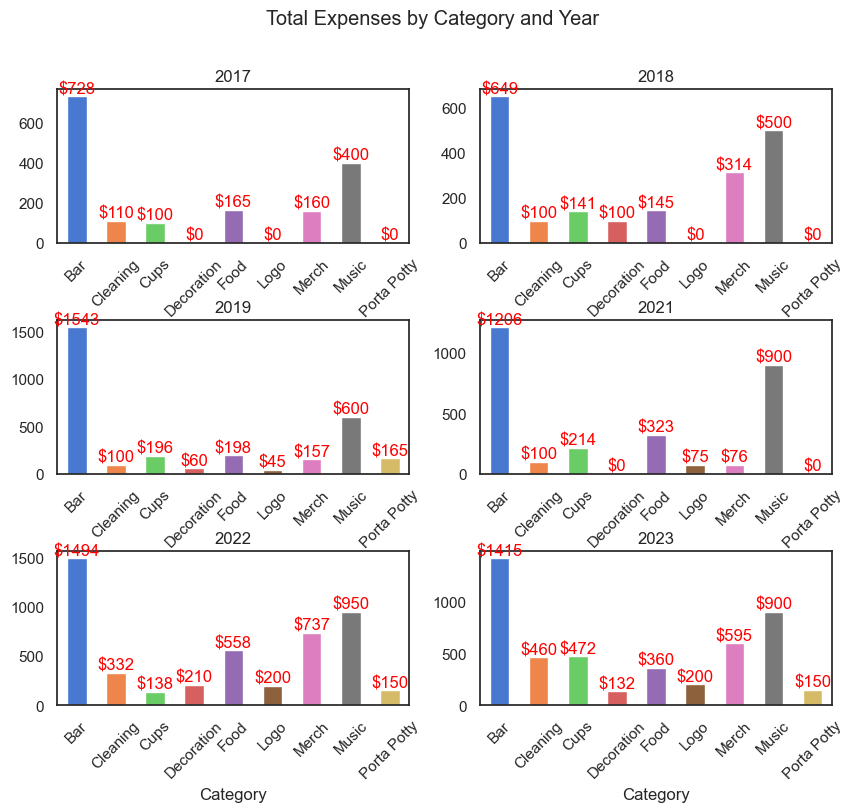

In [84]:
# plot a bar chart of every year's expenses by category

# group and sort sums by year
df_cat = df.groupby(["Year", "Category"])["Amount"].sum().reset_index()
# pivot df so each Category is a column
df_cat = df_cat.pivot(index="Year", columns="Category", values="Amount").reset_index()

# format overall figure
sns.set_theme(style="white")
fig, axs = plt.subplots(3, 2, figsize=(10, 8))

for i, ax in enumerate(axs.flatten()):
    if i < len(df_cat.Year):
        year = df_cat.Year[i]
        # plot the bar chart
        ax = df_cat.iloc[i, 1:].plot(
            kind="bar", color=sns.color_palette("muted"), ax=ax
        )

        # add labels
        for container in ax.containers:
            ax.bar_label(container, fmt="$%.0f", color="red")

        # format plot
        ax.set_title(year)
        ax.set_xticklabels(df_cat.columns[1:], rotation=45)
    else:
        # remove the unused subplot
        fig.delaxes(ax)

# adjust space between subplots
plt.subplots_adjust(hspace=0.5)

# format overall figure
plt.suptitle("Total Expenses by Category and Year")
plt.xlabel("Category")
plt.show()

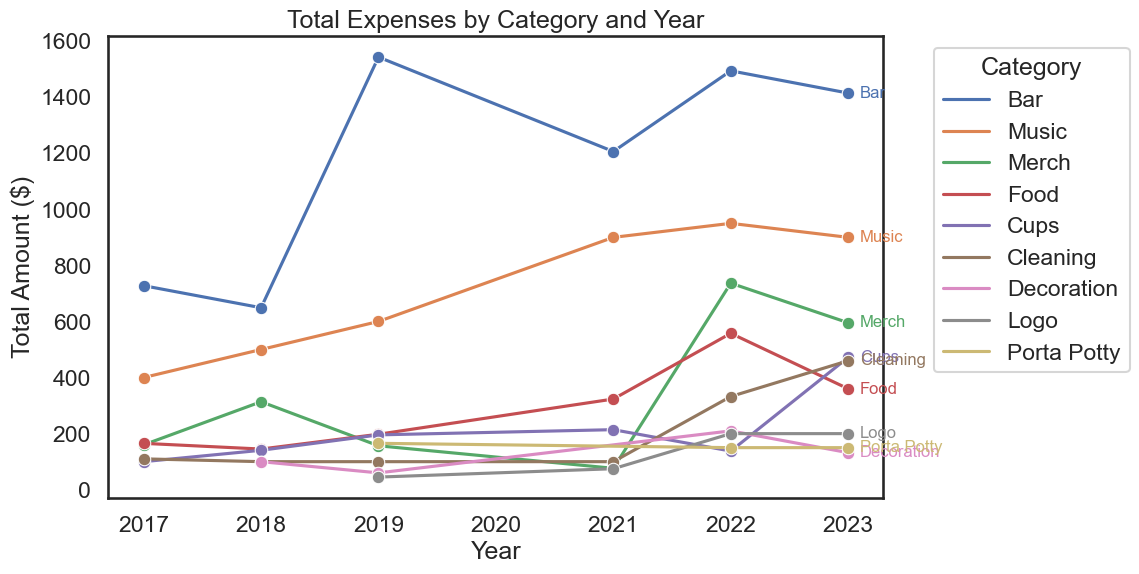

In [85]:
# line chart of expenses by category over time

# group and sort sums by Category and Year
df_cat_year_sum = df.groupby(["Category", "Year"]).sum().reset_index()
df_cat_year_sum = df_cat_year_sum.sort_values("Amount", ascending=False)

# plot the chart
sns.set_theme(style="white", context="talk")
plt.figure(figsize=(10, 6))
ax = sns.lineplot(
    x="Year", y="Amount", hue="Category", data=df_cat_year_sum, marker="o"
)

# annotate each line with the name of the category
for line, name in zip(ax.lines, df_cat_year_sum["Category"].unique()):
    y = line.get_ydata()[-1]
    x = line.get_xdata()[-1]
    ax.text(
        x + 0.1, y, name, color=line.get_color(), size=12, verticalalignment="center"
    )

# format plot
plt.title("Total Expenses by Category and Year")
plt.xlabel("Year")
plt.ylabel("Total Amount ($)")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

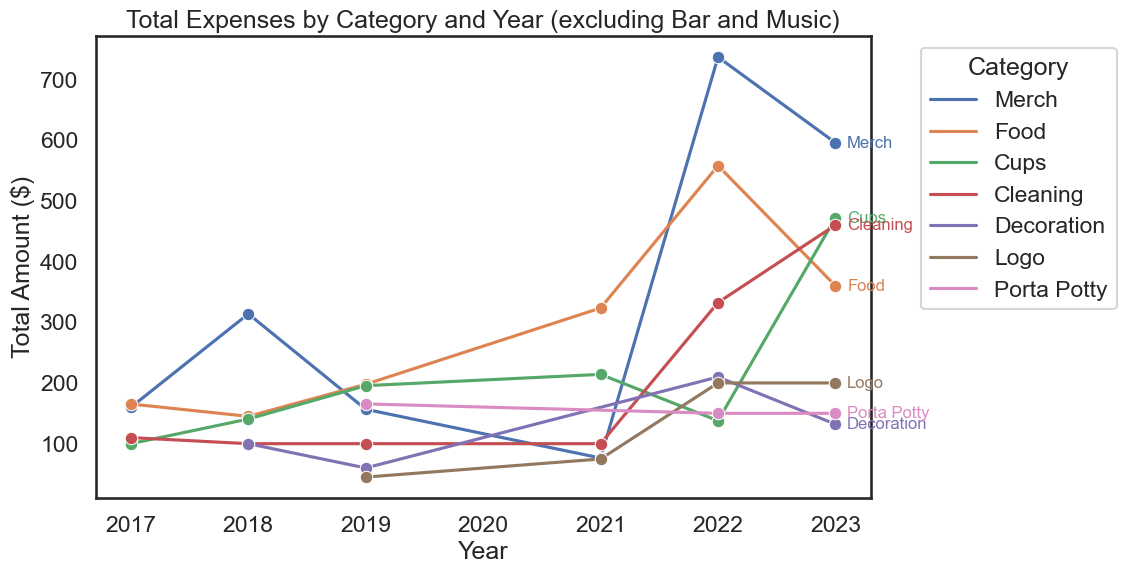

In [86]:
# line chart of expenses by category over time, without Bar and Music

# group and sort sums by Category and Year
df_cat_year_sum = df[df.Category != "Bar"]
df_cat_year_sum = df_cat_year_sum[df_cat_year_sum.Category != "Music"]
df_cat_year_sum = df_cat_year_sum.groupby(["Category", "Year"]).sum().reset_index()
df_cat_year_sum = df_cat_year_sum.sort_values("Amount", ascending=False)

# plot the chart
sns.set_theme(style="white", context="talk")
plt.figure(figsize=(10, 6))
ax = sns.lineplot(
    x="Year", y="Amount", hue="Category", data=df_cat_year_sum, marker="o"
)

# annotate each line with the name of the category
for line, name in zip(ax.lines, df_cat_year_sum["Category"].unique()):
    y = line.get_ydata()[-1]
    x = line.get_xdata()[-1]
    ax.text(
        x + 0.1, y, name, color=line.get_color(), size=12, verticalalignment="center"
    )

# format plot
plt.title("Total Expenses by Category and Year (excluding Bar and Music)")
plt.xlabel("Year")
plt.ylabel("Total Amount ($)")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

I think Food and Logo are worth investing in (and they are fulfilled by our friends). 

Merch escalates in cost - howsabout we just build a merch store (I suggest `Printful`, a Latvian custom-made-to=order schwag company) and let people order from there? Offload the task entirely? 

Cups: not sure what to do, but certainly try to order them in advance to cut down on rush shipping costs. 

Cleaning has escalated due to trying to have somebody clean up during the fiesta. It's really nice not having to do clean-up. This cost may be worth keeping.

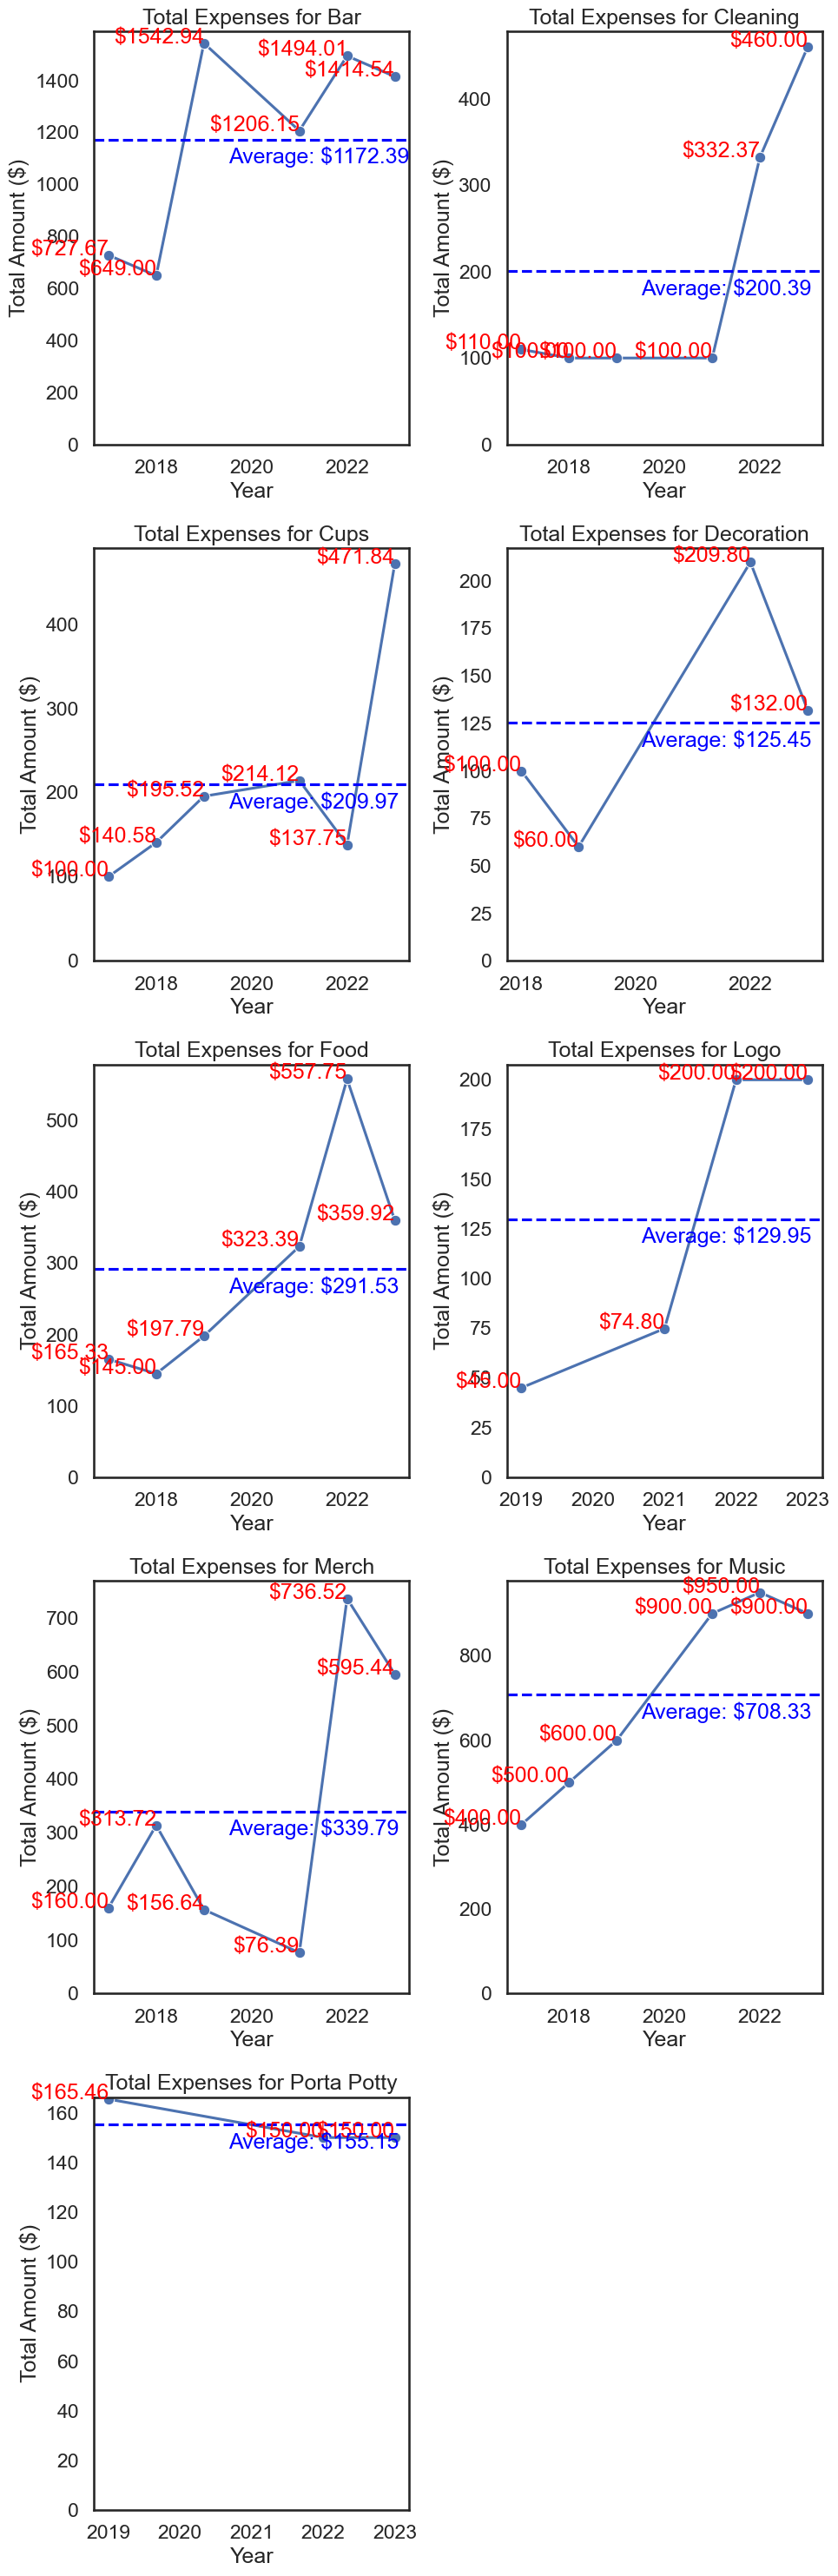

In [87]:
# line chart of expenses for each category over time, with average line

# group and sort sums by Category and Year
df_cat_year_sum = df.groupby(["Category", "Year"]).sum().reset_index()

# get unique categories
categories = df_cat_year_sum["Category"].unique()

# calculate the number of subplots you need
num_categories = len(categories)
num_rows = num_categories // 2 + num_categories % 2

# set the theme and create a figure
sns.set_theme(style="white", context="talk")
fig, axs = plt.subplots(num_rows, 2, figsize=(10, 6 * num_rows))

# flatten the axes array
axs = axs.flatten()

# plot a line chart for each category
for i, category in enumerate(categories):
    ax = axs[i]
    df_category = df_cat_year_sum[df_cat_year_sum["Category"] == category]
    lineplot = sns.lineplot(x="Year", y="Amount", data=df_category, marker="o", ax=ax)

    # annotate each data point with the total amount
    for x, y in zip(df_category["Year"], df_category["Amount"]):
        ax.text(x, y, f"${y:.2f}", color="red", ha="right")

    # add a line for the average Amount
    avg_amount = df_category["Amount"].mean()
    ax.axhline(avg_amount, color="blue", linestyle="--")

    # annotate the average line
    ax.annotate(
        f"Average: ${avg_amount:.2f}",
        xy=(1, avg_amount),
        xytext=(-150, -20),
        xycoords=("axes fraction", "data"),
        textcoords="offset points",
        color="blue",
    )

    # format plot
    ax.set_title(f"Total Expenses for {category}")
    ax.set_xlabel("Year")
    ax.set_ylabel("Total Amount ($)")
    ax.set_ylim(bottom=0)  # set y-axis to start at 0

# remove unused subplots
for i in range(num_categories, len(axs)):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

After spiking in 2019, Bar costs have remained fairly stable, although we should try to cut here if we can - it's the most expensive part of the budget.

Cleaning spiked because, starting in 2022, we now pay somebody to clean mid-party.

Not sure why Cups spiked in 2023. Other than avoiding rush orders, not sure what we can do here.

Decoration - nothing in 2017 or 2021. The 2022 spike is due to the banner.

Food spike due to the Cuban pig roast in 2022, and $234 in pizza from 2021. Also, this one suffers from my arbitrary split of Costco into 1/3 Food, 2/3rds Bar (assuming that plates, napkins, utensils, etc belong under 'Food').

Logo increased in 2022 because we now pay for a professional graphic designer.

Merch - schwag and T-shirts - only includes T-shirts for 2018, 2022, and 2023. $160, in 2017, is the highest Merch without T-shirts. Can we offload the shirts? Let's make an online store using Printful, and let people order their own damn T-shirt and have it delivered to their homes.

Music increased due to inflation. And Tom Brady hiding the true cost of bands. Can't cut costs here, unless we find volunteer bands.

Porta Potty. Pretty stable.

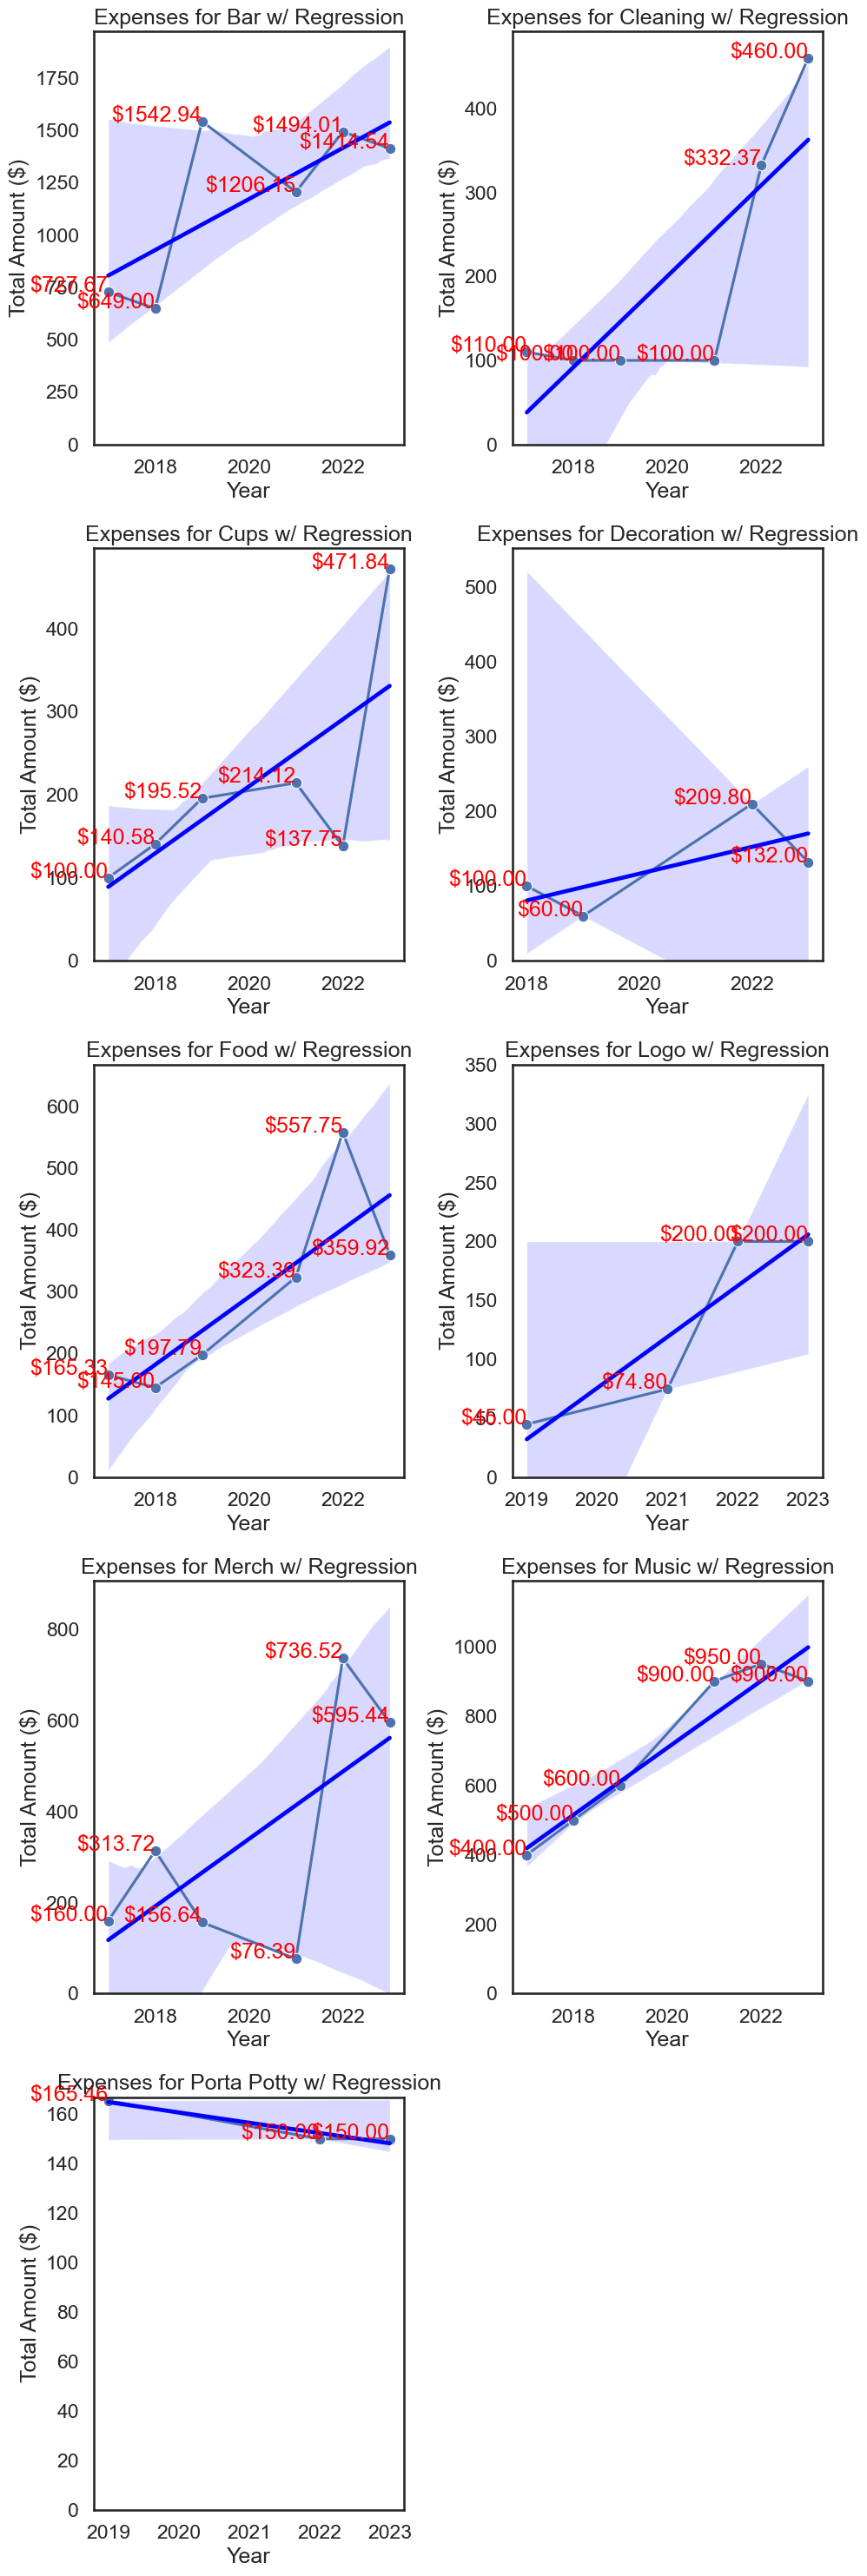

In [88]:
# line chart of expenses for each category over time, with regression line

# group and sort sums by Category and Year
df_cat_year_sum = df.groupby(["Category", "Year"]).sum().reset_index()

# get unique categories
categories = df_cat_year_sum["Category"].unique()

# calculate the number of subplots you need
num_categories = len(categories)
num_rows = num_categories // 2 + num_categories % 2

# set the theme and create a figure
sns.set_theme(style="white", context="talk")
fig, axs = plt.subplots(num_rows, 2, figsize=(10, 6 * num_rows))

# flatten the axes array
axs = axs.flatten()

# plot a line chart for each category
for i, category in enumerate(categories):
    ax = axs[i]
    df_category = df_cat_year_sum[df_cat_year_sum["Category"] == category]
    lineplot = sns.lineplot(x="Year", y="Amount", data=df_category, marker="o", ax=ax)

    # annotate each data point with the total amount
    for x, y in zip(df_category["Year"], df_category["Amount"]):
        ax.text(x, y, f"${y:.2f}", color="red", ha="right")

    # add a regression line
    sns.regplot(
        x="Year", y="Amount", data=df_category, scatter=False, ax=ax, color="blue"
    )

    # format plot
    ax.set_title(f"Expenses for {category} w/ Regression")
    ax.set_xlabel("Year")
    ax.set_ylabel("Total Amount ($)")
    ax.set_ylim(bottom=0)  # set y-axis to start at 0

# remove unused subplots
for i in range(num_categories, len(axs)):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

The blue shaded area represents the confidence interval. If further data were added and a new regression line calculated, there's a (probably) 95% chance that the new regression line would fall within that shaded area.

The wider the shaded area, the more uncertainty, unsurprising given our small sample size.

Obviously, take these regression lines with a grain of salt. While they show the clear trend of increasing costs over time, some of them (like Music and Logo) have merely stabilized at a new, higher cost.

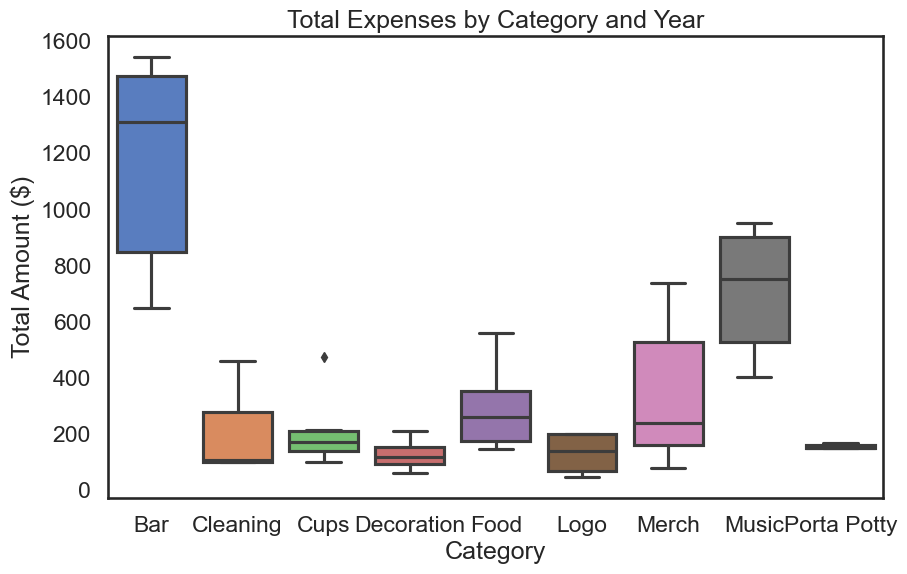

In [89]:
# box plot of each category's expenses over time

# group and sort sums by Category and Year
df_cat_year_sum = df.groupby(["Category", "Year"]).sum().reset_index()

# plot the chart
sns.set_theme(style="white", context="talk")
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x="Category", y="Amount", data=df_cat_year_sum, palette="muted")

# format plot
plt.title("Total Expenses by Category and Year")
plt.xlabel("Category")
plt.ylabel("Total Amount ($)")
plt.show()

**Box plot refresher**:

A box plot, also known as a box-and-whisker plot, is a graphical representation of statistical data based on a five-number summary. 

- Minimum: The lowest point (not including outliers) represented by the end of the lower whisker.

- First Quartile (Q1): The 25th percentile of the data. 25% of data points are less than or equal to this value. It's represented by the lower edge of the box.

- Median (Q2): The 50th percentile of the data. This is the middle value of the dataset, with 50% of data points less than this value and 50% greater. It's represented by the line inside the box.

- Third Quartile (Q3): The 75th percentile of the data. 75% of data points are less than or equal to this value. It's represented by the upper edge of the box.

- Maximum: The highest point (not including outliers) represented by the end of the upper whisker.

Interquartile Range (IQR): The range between the first quartile and the third quartile (Q3 - Q1). It represents the middle 50% of the data. It's represented by the box itself.

Outliers: Data points that fall below Q1 - 1.5IQR or above Q3 + 1.5IQR. They are typically represented by dots or asterisks.

Whiskers: The lines extending from the box indicate variability outside the upper and lower quartiles, a.k.a., the max and min excluding outliers.

The box plot is useful for identifying outliers, variability, and skewness in the data. It provides a visual summary of the data's minimum, maximum, median, and quartiles.

**Below are two more versions, that should make this clearer**

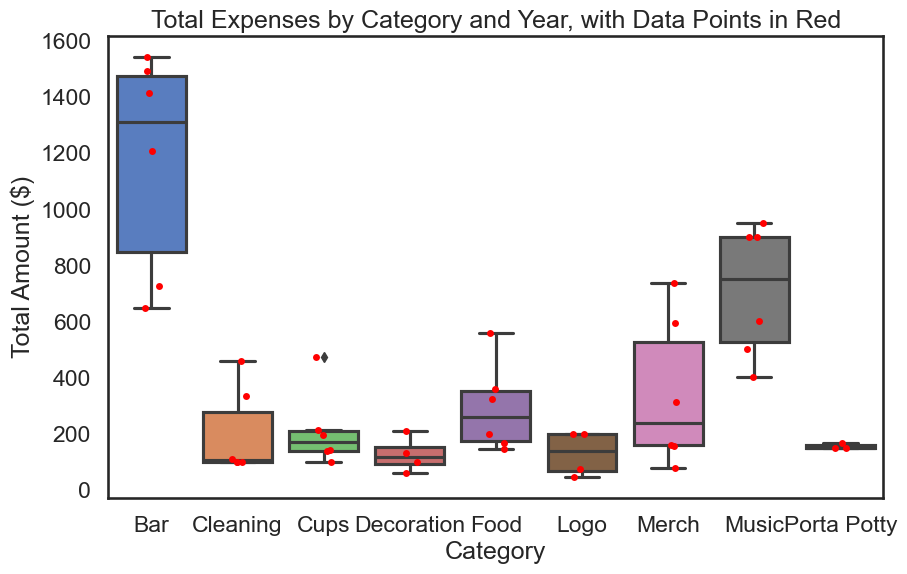

In [90]:
# box plot of each category's expenses over time

# group and sort sums by Category and Year
df_cat_year_sum = df.groupby(["Category", "Year"]).sum().reset_index()

# plot the chart
sns.set_theme(style="white", context="talk")
plt.figure(figsize=(10, 6))

# create boxplot
ax = sns.boxplot(x="Category", y="Amount", data=df_cat_year_sum, palette="muted")

# add stripplot with jitter to show individual data points
sns.stripplot(x="Category", y="Amount", data=df_cat_year_sum, color="red", jitter=True)

# format plot
plt.title("Total Expenses by Category and Year, with Data Points in Red")
plt.xlabel("Category")
plt.ylabel("Total Amount ($)")
plt.show()

In [91]:
# group and sort sums by Category and Year
df_cat_year_sum = df.groupby(["Category", "Year"]).sum().reset_index()

# create boxplot with all points and a different color for each category
fig = px.box(
    df_cat_year_sum,
    x="Category",
    y="Amount",
    color="Category",
    points="all",
    hover_data={"Amount": ":$.2f", "Year": True},
)

# format plot
fig.update_layout(
    title="Total Expenses by Category and Year (Hover for more info)",
    xaxis_title="Category",
    yaxis_title="Total Amount ($)",
)

# show the plot
fig.show()

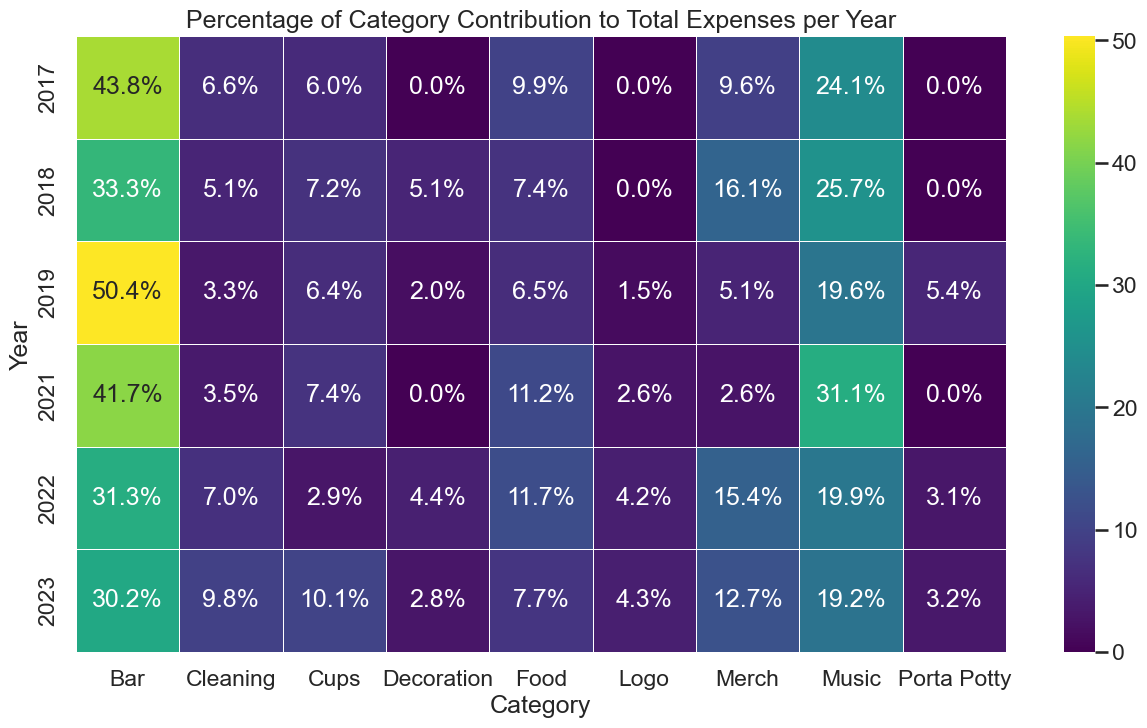

In [92]:
# heatmap variant of percentage of category per year to total expenses per year

# calculate total expenses per year
total_expenses_per_year = (
    df.groupby("Year")["Amount"]
    .sum()
    .reset_index()
    .rename(columns={"Amount": "Total Expenses"})
)

# merge total expenses with df
df_expenses = pd.merge(df, total_expenses_per_year, on="Year", how="left")

# create pivot table
pivot_expenses = df_expenses.pivot_table(
    index="Year", columns="Category", values="Amount", aggfunc="sum", fill_value=0
)

# normalize data
pivot_expenses_norm = pivot_expenses.div(pivot_expenses.sum(axis=1), axis=0) * 100


# custom annotation function
def fmt(x):
    return "{:.1f}%".format(x)


# plot heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(
    pivot_expenses_norm,
    annot=np.vectorize(fmt)(pivot_expenses_norm.values),
    fmt="",
    cmap="viridis",
    linewidths=0.5,
)
plt.title("Percentage of Category Contribution to Total Expenses per Year")
plt.show()

## Reimbursements

- [Back to Table of Contents](#table-of-contents)

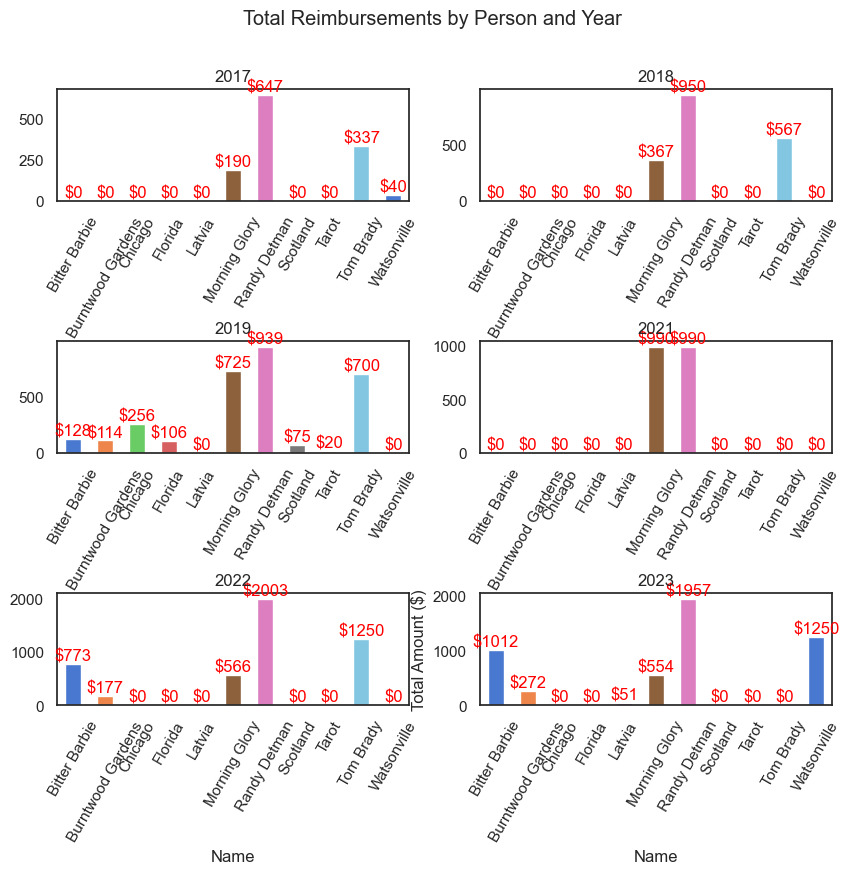

In [93]:
# plot a bar chart of every person's total pay outs by year

# group and sort sums by year
reim_sum = reim_df.groupby(["Year", "Name"])["Paid"].sum().reset_index()
reim_sum = reim_sum.pivot(index="Year", columns="Name", values="Paid").reset_index()
reim_sum = reim_sum.fillna(0)

# format overall figure
sns.set_theme(style="white")
fig, axs = plt.subplots(3, 2, figsize=(10, 8))
plt.ylabel("Total Amount ($)")
plt.xlabel("Year")

for i, ax in enumerate(axs.flatten()):
    if i < len(reim_sum.Year):
        year = reim_sum.Year[i]
        # plot the bar chart
        ax = reim_sum.iloc[i, 1:].plot(
            kind="bar", color=sns.color_palette("muted"), ax=ax
        )

        # add labels
        for container in ax.containers:
            ax.bar_label(container, fmt="$%.0f", color="red")

        # format plot
        ax.set_title(year)
        ax.set_xticklabels(reim_sum.columns[1:], rotation=60)
    else:
        # remove the unused subplot, because 2020 was heinous and matplotlib throws a deprecation warning
        fig.delaxes(ax)

# adjust space between subplots
plt.subplots_adjust(hspace=1.25)

# format overall figure
plt.suptitle("Total Reimbursements by Person and Year")
plt.show()

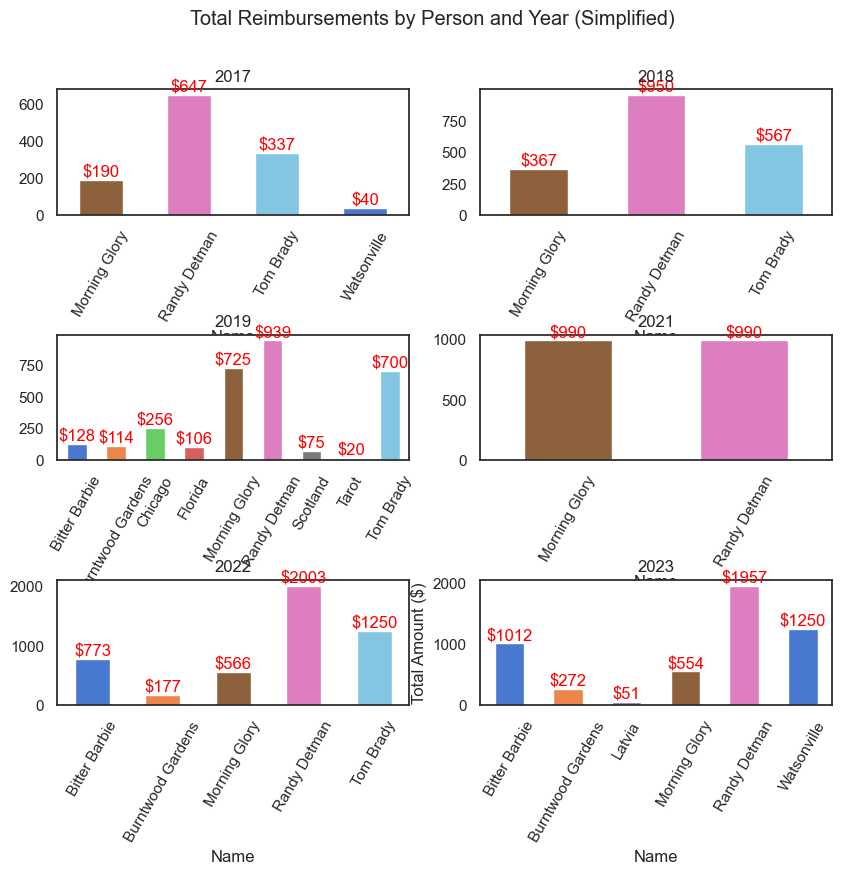

In [94]:
# plot a bar chart of every person's total reimbursements by year, removing nulls

# group and sort sums by year
reim_sum = reim_df.groupby(["Year", "Name"])["Paid"].sum().reset_index()
reim_sum = reim_sum.pivot(index="Year", columns="Name", values="Paid").reset_index()
reim_sum = reim_sum.fillna(0)

# create a color dictionary
unique_names = reim_sum.columns[1:]
color_palette = sns.color_palette("muted", n_colors=len(unique_names))
color_dict = {name: color for name, color in zip(unique_names, color_palette)}

# format overall figure
sns.set_theme(style="white")
fig, axs = plt.subplots(3, 2, figsize=(10, 8))
plt.ylabel("Total Amount ($)")
plt.xlabel("Year")

for i, ax in enumerate(axs.flatten()):
    if i < len(reim_sum.Year):
        year = reim_sum.Year[i]
        # filter out the people who did not contribute in the year
        year_data = reim_sum.iloc[i, 1:]
        contributors = year_data[year_data > 0]

        # plot the bar chart with consistent colors
        contributors.plot(
            kind="bar", color=[color_dict[name] for name in contributors.index], ax=ax
        )

        # add labels
        for container in ax.containers:
            ax.bar_label(container, fmt="$%.0f", color="red")

        # format plot
        ax.set_title(year)
        ax.set_xticklabels(contributors.index, rotation=60)
    else:
        # remove the unused subplot, because 2020 was heinous and matplotlib throws a deprecation warning
        fig.delaxes(ax)

# adjust space between subplots
plt.subplots_adjust(hspace=0.95)

# format overall figure
plt.suptitle("Total Reimbursements by Person and Year (Simplified)")
plt.show()

In [95]:
# # plot a bar chart of every person's total pay_outs by year
# # this version doesn't throw a deprecation flag (Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later)

# # group and sort sums by year
# reim_sum = reim_df.groupby(["Year", "Name"])["Paid"].sum().reset_index()
# reim_sum = reim_sum.pivot(index="Year", columns="Name", values="Paid").reset_index()
# reim_sum = reim_sum.fillna(0)

# # format overall figure
# sns.set_theme(style="white")
# fig, axs = plt.subplots(3, 2, figsize=(10, 8))  # Create a grid of 3x2 subplots
# axs = axs.flatten()  # Flatten the grid to a 1D array for easy iteration

# for i, year in enumerate(reim_sum.Year):
#     # plot the bar chart on the i-th subplot
#     ax = reim_sum.iloc[i, 1:].plot(kind="bar", color=sns.color_palette("muted"), ax=axs[i])

#     # add labels
#     for container in ax.containers:
#         ax.bar_label(container)

#     # format plot
#     ax.set_title(year)
#     ax.set_ylabel("Total Amount ($)")
#     ax.set_xlabel("Year")
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=60)

# # Remove unused subplots
# for j in range(i+1, len(axs)):
#     fig.delaxes(axs[j])

# # adjust space between subplots
# plt.subplots_adjust(hspace=1.25)

# # format overall figure
# plt.suptitle("Total Reimbursements by Person and Year")
# plt.show()

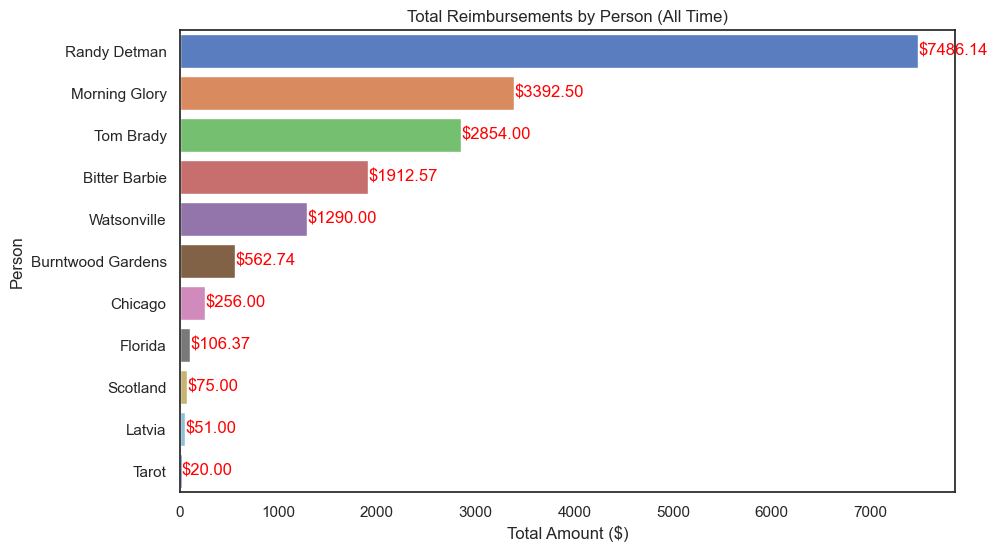

In [96]:
# plot bar chart of every person's total pay_outs

# group and sort sums by year
reim_sum = reim_df.groupby("Name")["Paid"].sum().reset_index()
reim_sum = reim_sum.sort_values("Paid", ascending=False)

# plot the chart
sns.set_theme(style="white")
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="Paid", y="Name", data=reim_sum, palette="muted")

# add labels
for container in ax.containers:
    ax.bar_label(container, fmt="$%.2f", color="red")

# format plot
plt.title("Total Reimbursements by Person (All Time)")
plt.xlabel("Total Amount ($)")
plt.ylabel("Person")
plt.show()

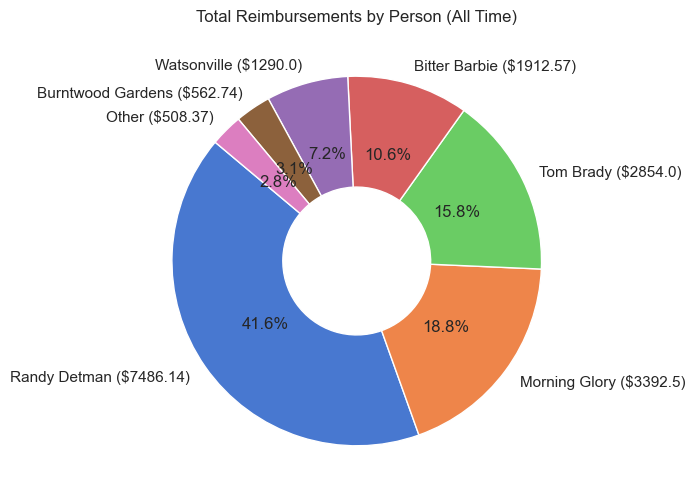

In [97]:
# plot pie chart of every person's total pay_outs

# group sums by name
reim_sum = reim_df.groupby("Name")["Paid"].sum().reset_index()

# calculate percentage of total for each person
reim_sum["Percentage"] = 100 * reim_sum["Paid"] / reim_sum["Paid"].sum()

# replace names of those with less than 3% with 'Other'
reim_sum.loc[reim_sum["Percentage"] < 3, "Name"] = "Other"

# group by name again to combine all 'Other' rows
reim_sum = reim_sum.groupby("Name")["Paid"].sum().reset_index()

# sort df
reim_sum = reim_sum.sort_values("Paid", ascending=False)

# new column for labels (name and amount)
reim_sum["Label"] = (
    reim_sum["Name"] + " ($" + reim_sum["Paid"].round(2).astype(str) + ")"
)

# plot chart
sns.set_theme(style="white")
plt.figure(figsize=(10, 6))
plt.pie(
    reim_sum.Paid,
    labels=reim_sum.Label,
    autopct="%1.1f%%",
    startangle=140,
    colors=sns.color_palette("muted"),
    wedgeprops=dict(width=0.6, edgecolor="w"),
)
plt.title("Total Reimbursements by Person (All Time)")
plt.show()

Shout out to Randy Detman, for having the most skin in the game.

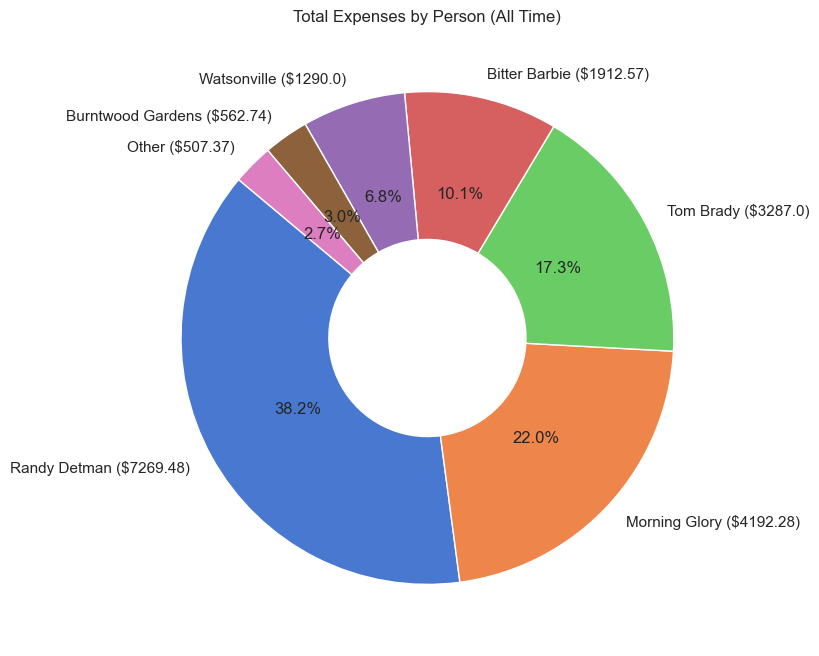

In [98]:
# plot pie chart of every person's total expenses paid over time, including "Other" category

# group and sort sums by name
df_sum = df.groupby(["Name"])["Amount"].sum().reset_index()

# calculate percentage of total for each person
df_sum["Percentage"] = 100 * df_sum["Amount"] / df_sum["Amount"].sum()

# replace names of those with less than 3% with 'Other'
df_sum.loc[df_sum["Percentage"] < 2.9, "Name"] = "Other"

# group by name again to combine all 'Other' rows
df_sum = df_sum.groupby("Name")["Amount"].sum().reset_index()

# sort df
df_sum = df_sum.sort_values("Amount", ascending=False)

# new column for the labels (name and amount)
df_sum["Label"] = df_sum["Name"] + " ($" + df_sum["Amount"].round(2).astype(str) + ")"

# format overall figure
sns.set_theme(style="white")
plt.figure(figsize=(10, 8))
plt.pie(
    df_sum.Amount,
    labels=df_sum.Label,
    autopct="%1.1f%%",
    startangle=140,
    colors=sns.color_palette("muted"),
    wedgeprops=dict(width=0.6, edgecolor="w"),
)
plt.title("Total Expenses by Person (All Time)")
plt.show()

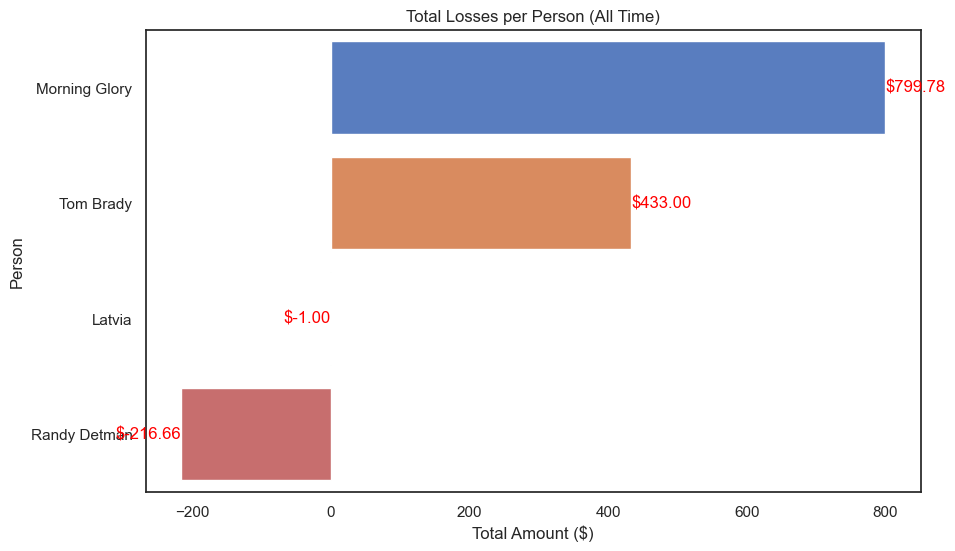

In [99]:
# plot total losses per person, ignore nulls, losses are total expenses minus pay_outs

# group and sort sums by year
reim_sum = reim_df.groupby("Name")["Paid"].sum().reset_index()
reim_sum = reim_sum.sort_values("Paid", ascending=False)

# group and sort sums by year
df_sum = df.groupby("Name")["Amount"].sum().reset_index()
df_sum = df_sum.sort_values("Amount", ascending=False)

# merge dfs
losses = pd.merge(df_sum, reim_sum, on="Name", how="outer")
losses = losses.fillna(0)
losses["Losses"] = losses.Amount - losses.Paid
losses = losses.sort_values("Losses", ascending=False)

# Filter out people with zero losses
losses = losses[losses.Losses != 0]

# plot the chart
sns.set_theme(style="white")
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="Losses", y="Name", data=losses, palette="muted")

# add labels
for container in ax.containers:
    ax.bar_label(container, fmt="$%.2f", color="red")

# format plot
plt.title("Total Losses per Person (All Time)")
plt.xlabel("Total Amount ($)")
plt.ylabel("Person")
plt.show()

Notes: Most of this is 2021. 2021 hurt. Covid knocked Harvest Party down to life support mode. 

Randy Detman has actually turned a profit, due to the profit from 2023.

Tom Brady has probably lost more than this, being sneaky and not charging the full cost of music (2017 is an estimate, and I'm skeptical of 2018's Music expenses as well). 

Latvia got an extra buck for being a good person (and the extra dollar had to go somewhere)

## Attendees

- [Back to Table of Contents](#table-of-contents)

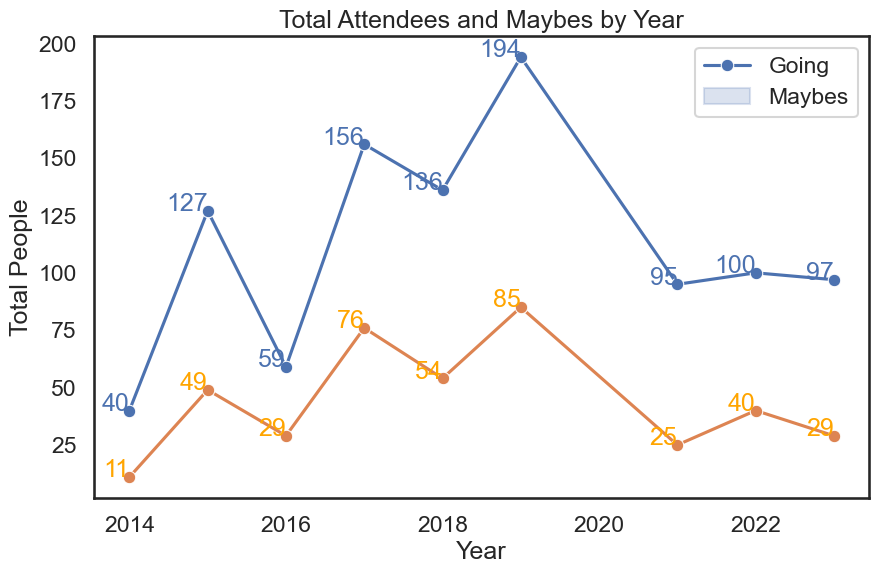

In [100]:
# line chart of attendees and maybes by year

# plot the chart
sns.set_theme(style="white", context="talk")
plt.figure(figsize=(10, 6))
sns.lineplot(x="Year", y="Going", data=att_df, marker="o")
sns.lineplot(x="Year", y="Maybes", data=att_df, marker="o")

# annotate each data point
for _, row in att_df.iterrows():
    year = row.Year
    going = row.Going
    maybes = row.Maybes
    plt.text(year, going, f"{going}", horizontalalignment="right", color="b")
    plt.text(year, maybes, f"{maybes}", horizontalalignment="right", color="orange")

# format plot
plt.title("Total Attendees and Maybes by Year")
plt.xlabel("Year")
plt.ylabel("Total People")
plt.legend(["Going", "Maybes"])
plt.show()

The decline and stabilization of attendees probably reflects the decline of Facebook. Question: Is there any other reason for the decline?

Average percentage of maybes: 38.19%


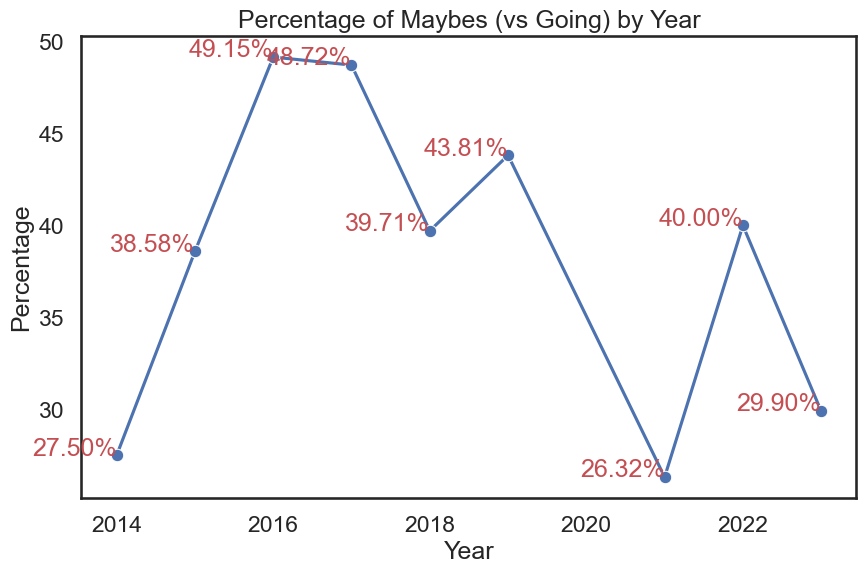

In [101]:
# line plot of percent of maybes versus going per year

# calculate percentage of maybes for each year
att_df_copy = att_df.copy()
att_df_copy["Percentage_maybes"] = att_df_copy["Maybes"] / (att_df_copy["Going"]) * 100

print(f"Average percentage of maybes: {att_df_copy.Percentage_maybes.mean():.2f}%")

# plot the chart
sns.set_theme(style="white", context="talk")
plt.figure(figsize=(10, 6))
sns.lineplot(x="Year", y="Percentage_maybes", data=att_df_copy, marker="o")

# annotate each data point
for _, row in att_df_copy.iterrows():
    year = row.Year
    percentage = row.Percentage_maybes
    plt.text(
        year, percentage, f"{percentage:.2f}%", horizontalalignment="right", color="r"
    )

# format plot
plt.title("Percentage of Maybes (vs Going) by Year")
plt.xlabel("Year")
plt.ylabel("Percentage")
plt.show()

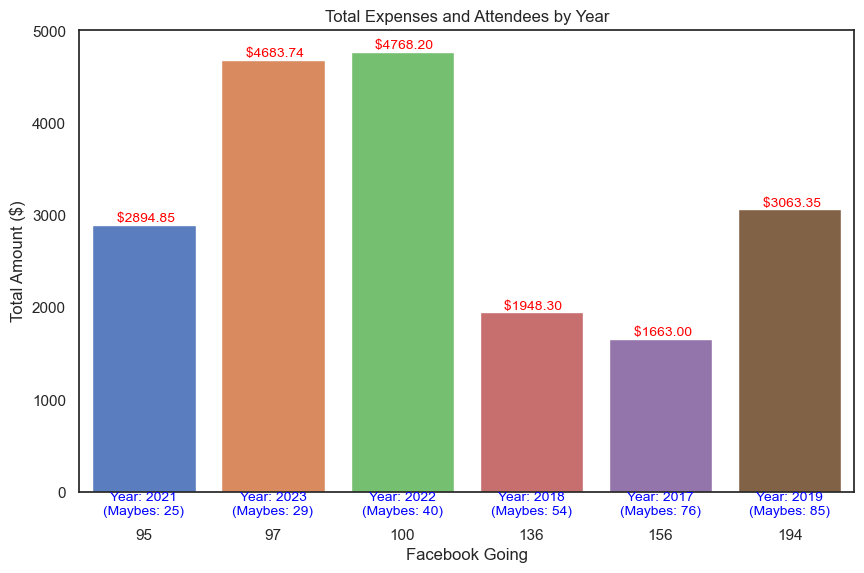

In [102]:
# barplot of Facebook Going vs total expenses by year

# group and sort sums by year, 2017+
df_sum = df[df.Year >= 2017].groupby("Year")["Amount"].sum().reset_index()
att_sum = att_df[att_df.Year >= 2017].copy()

# merge dfs
df_att = pd.merge(df_sum, att_sum, on="Year", how="outer")

# sort by 'Going'
df_att.sort_values("Going", inplace=True)

# plot the chart
sns.set_theme(style="white")
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="Going", y="Amount", data=df_att, palette="muted")

# add labels
for i, bar in enumerate(ax.patches):
    # print the sum at the top of each bar
    ax.text(
        bar.get_x() + bar.get_width() / 2.0,
        bar.get_height(),
        " ${:.2f}".format(bar.get_height()),
        ha="center",
        va="bottom",
        color="red",
        size="small",
    )
    # print the Year and Maybes at the bottom of each bar
    ax.text(
        bar.get_x() + bar.get_width() / 2.0,
        0,
        "Year: {}\n(Maybes: {})".format(
            df_att["Year"].values[i], df_att["Maybes"].values[i]
        ),
        ha="center",
        va="top",
        color="blue",
        size="small",
    )

# move xticks down
for tick in ax.get_xticklabels():
    tick.set_y(-0.05)

# format plot
plt.title("Total Expenses and Attendees by Year")
plt.xlabel("Facebook Going")
plt.ylabel("Total Amount ($)")
plt.show()

We do have fewer attendees and higher expenses post-covid. I would argue this is further evidence of the decoupling of Facebook invites from actual attendees, combined with inflation and inceasing expenses.

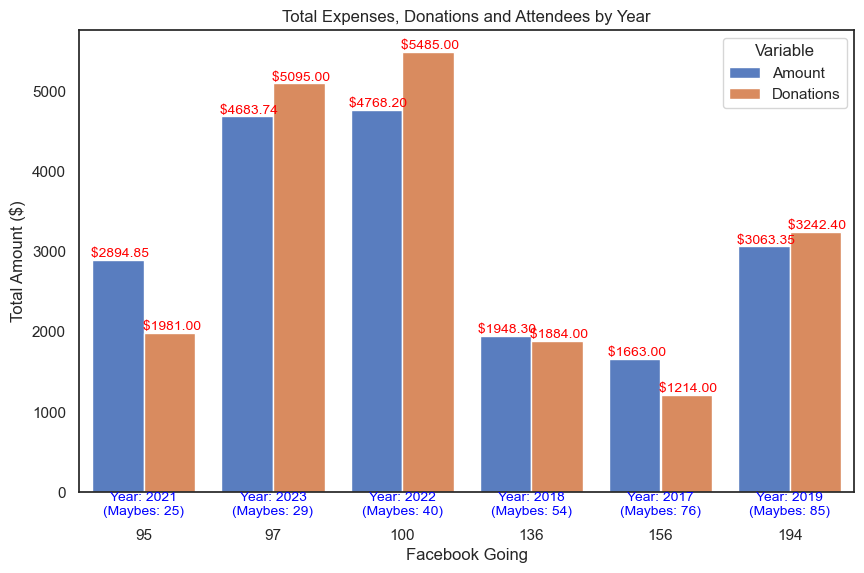

In [103]:
# barplot of Facebook Going vs total expenses and donations by year

# group and sort sums by year, 2017+
df_sum = df[df.Year >= 2017].groupby("Year")["Amount"].sum().reset_index()
att_sum = att_df[att_df.Year >= 2017].copy()

# merge dfs
df_att = pd.merge(df_sum, att_sum, on="Year", how="outer")

# merge donations df with df_att
df_att = pd.merge(df_att, don_df, on="Year", how="outer")

# sort by 'Going'
df_att.sort_values("Going", inplace=True)

# reshape data to long format
df_long = pd.melt(
    df_att, id_vars=["Year", "Going", "Maybes"], value_vars=["Amount", "Donations"]
)

# plot the chart
sns.set_theme(style="white")
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="Going", y="value", hue="variable", data=df_long, palette="muted")

# add labels
for i, bar in enumerate(ax.patches):
    # print the sum at the top of each bar
    ax.text(
        bar.get_x() + bar.get_width() / 2.0,
        bar.get_height(),
        " ${:.2f}".format(bar.get_height()),
        ha="center",
        va="bottom",
        color="red",
        size="small",
    )

# print the Year and Maybes at the bottom of each pair of bars
for i in range(len(df_att)):
    ax.text(
        i,
        0,
        "Year: {}\n(Maybes: {})".format(
            df_att["Year"].values[i], df_att["Maybes"].values[i]
        ),
        ha="center",
        va="top",
        color="blue",
        size="small",
    )

# move xticks down
for tick in ax.get_xticklabels():
    tick.set_y(-0.05)

# format plot
plt.title("Total Expenses, Donations and Attendees by Year")
plt.xlabel("Facebook Going")
plt.ylabel("Total Amount ($)")
plt.legend(title="Variable")
plt.show()

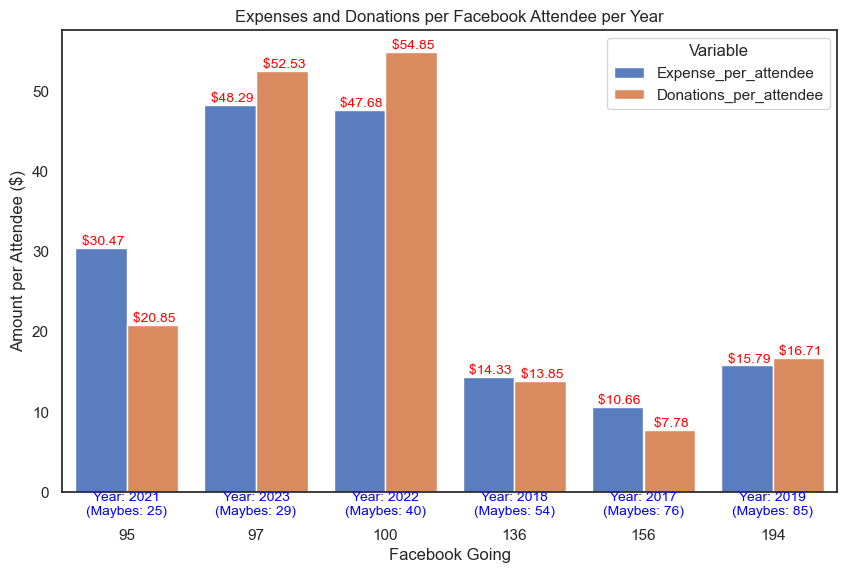

In [104]:
# barplot of Facebook Going vs expenses and donations per attendee per year

# group and sort sums by year, 2017+
df_sum = df[df.Year >= 2017].groupby("Year")["Amount"].sum().reset_index()
att_sum = att_df[att_df.Year >= 2017].copy()

# merge dfs
df_att = pd.merge(df_sum, att_sum, on="Year", how="outer")

# merge donations df with df_att
df_att = pd.merge(df_att, don_df, on="Year", how="outer")

# sort by 'Going'
df_att.sort_values("Going", inplace=True)

# calculate expenses and donations per Facebook attendee
df_att["Expense_per_attendee"] = df_att["Amount"] / df_att["Going"]
df_att["Donations_per_attendee"] = df_att["Donations"] / df_att["Going"]

# reshape data to long format
df_long = pd.melt(
    df_att,
    id_vars=["Year", "Going", "Maybes"],
    value_vars=["Expense_per_attendee", "Donations_per_attendee"],
)

# plot the chart
sns.set_theme(style="white")
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="Going", y="value", hue="variable", data=df_long, palette="muted")

# add labels
for i, bar in enumerate(ax.patches):
    # print the sum at the top of each bar
    ax.text(
        bar.get_x() + bar.get_width() / 2.0,
        bar.get_height(),
        " ${:.2f}".format(bar.get_height()),
        ha="center",
        va="bottom",
        color="red",
        size="small",
    )

# print the Year and Maybes at the bottom of each pair of bars
for i in range(len(df_att)):
    ax.text(
        i,
        0,
        "Year: {}\n(Maybes: {})".format(
            df_att["Year"].values[i], df_att["Maybes"].values[i]
        ),
        ha="center",
        va="top",
        color="blue",
        size="small",
    )

# move xticks down
for tick in ax.get_xticklabels():
    tick.set_y(-0.05)

# format plot
plt.title("Expenses and Donations per Facebook Attendee per Year")
plt.xlabel("Facebook Going")
plt.ylabel("Amount per Attendee ($)")
plt.legend(title="Variable")
plt.show()

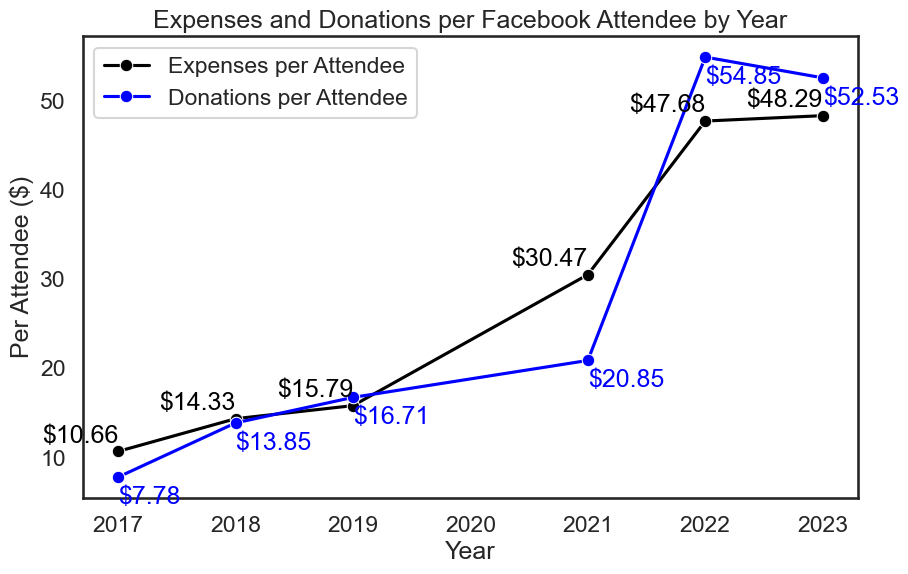

In [105]:
# plot of expenses per attendee by year

# group and sort sums by year, 2017+
df_sum = df[df.Year >= 2017].groupby("Year")["Amount"].sum().reset_index()
att_sum = att_df[att_df.Year >= 2017].copy()

# merge dfs
df_sum = pd.merge(df_sum, att_sum, on="Year", how="outer")

# calculate expenses per attendee
df_sum["Expenses_per_attendee"] = df_sum["Amount"] / df_sum["Going"]

# merge don_df with df_sum
df_sum = pd.merge(df_sum, don_df, on="Year", how="outer")

# calculate donations per attendee
df_sum["Donations_per_attendee"] = df_sum["Donations"] / df_sum["Going"]

# plot and format line chart for expenses
sns.set_theme(style="white", context="talk")
plt.figure(figsize=(10, 6))
sns.lineplot(
    x="Year",
    y="Expenses_per_attendee",
    data=df_sum,
    marker="o",
    color="black",
    label="Expenses per Attendee",
)

# plot and format line chart for donations
sns.lineplot(
    x="Year",
    y="Donations_per_attendee",
    data=df_sum,
    marker="o",
    color="blue",
    label="Donations per Attendee",
)

# annotate each data point for expenses
for _, row in df_sum.iterrows():
    year = row.Year
    amount = row.Expenses_per_attendee
    plt.text(
        year, amount + 1, f"${amount:.2f}", horizontalalignment="right", color="black"
    )

# annotate each data point for donations
for _, row in df_sum.iterrows():
    year = row.Year
    donation = row.Donations_per_attendee
    plt.text(
        year, donation - 3, f"${donation:.2f}", horizontalalignment="left", color="blue"
    )

# format plot
plt.title("Expenses and Donations per Facebook Attendee by Year")
plt.xlabel("Year")
plt.ylabel("Per Attendee ($)")
plt.show()

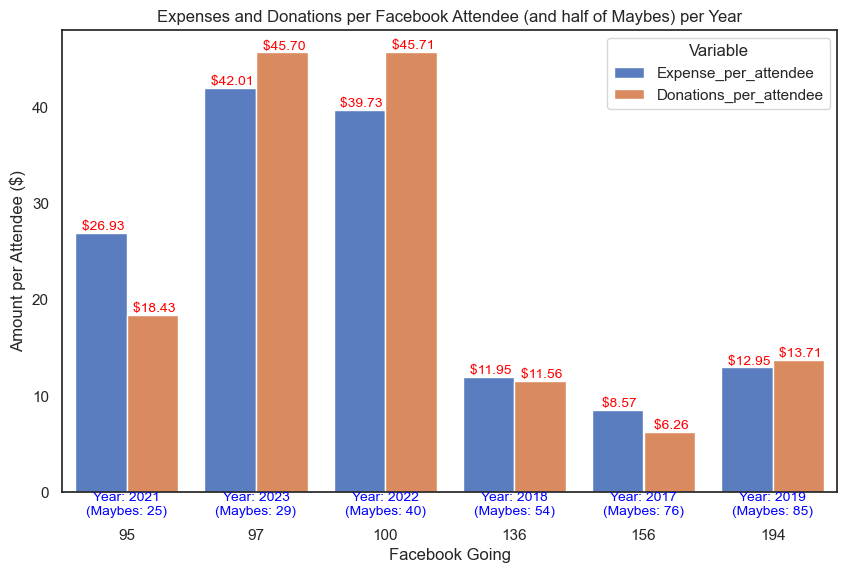

In [106]:
# barplot of Facebook Going vs expenses and donations per attendee (& half of Maybes) per year

# group and sort sums by year, 2017+
df_sum = df[df.Year >= 2017].groupby("Year")["Amount"].sum().reset_index()
att_sum = att_df[att_df.Year >= 2017].copy()

# merge dfs
df_att = pd.merge(df_sum, att_sum, on="Year", how="outer")

# merge donations df with df_att
df_att = pd.merge(df_att, don_df, on="Year", how="outer")

# sort by 'Going'
df_att.sort_values("Going", inplace=True)

# calculate expenses and donations per Facebook attendee
df_att["Expense_per_attendee"] = df_att["Amount"] / (
    df_att["Going"] + df_att["Maybes"] / 2
)
df_att["Donations_per_attendee"] = df_att["Donations"] / (
    df_att["Going"] + df_att["Maybes"] / 2
)

# reshape data to long format
df_long = pd.melt(
    df_att,
    id_vars=["Year", "Going", "Maybes"],
    value_vars=["Expense_per_attendee", "Donations_per_attendee"],
)

# plot the chart
sns.set_theme(style="white")
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="Going", y="value", hue="variable", data=df_long, palette="muted")

# add labels
for i, bar in enumerate(ax.patches):
    # print the sum at the top of each bar
    ax.text(
        bar.get_x() + bar.get_width() / 2.0,
        bar.get_height(),
        " ${:.2f}".format(bar.get_height()),
        ha="center",
        va="bottom",
        color="red",
        size="small",
    )

# print the Year and Maybes at the bottom of each pair of bars
for i in range(len(df_att)):
    ax.text(
        i,
        0,
        "Year: {}\n(Maybes: {})".format(
            df_att["Year"].values[i], df_att["Maybes"].values[i]
        ),
        ha="center",
        va="top",
        color="blue",
        size="small",
    )

# move xticks down
for tick in ax.get_xticklabels():
    tick.set_y(-0.05)

# format plot
plt.title("Expenses and Donations per Facebook Attendee (and half of Maybes) per Year")
plt.xlabel("Facebook Going")
plt.ylabel("Amount per Attendee ($)")
plt.legend(title="Variable")
plt.show()

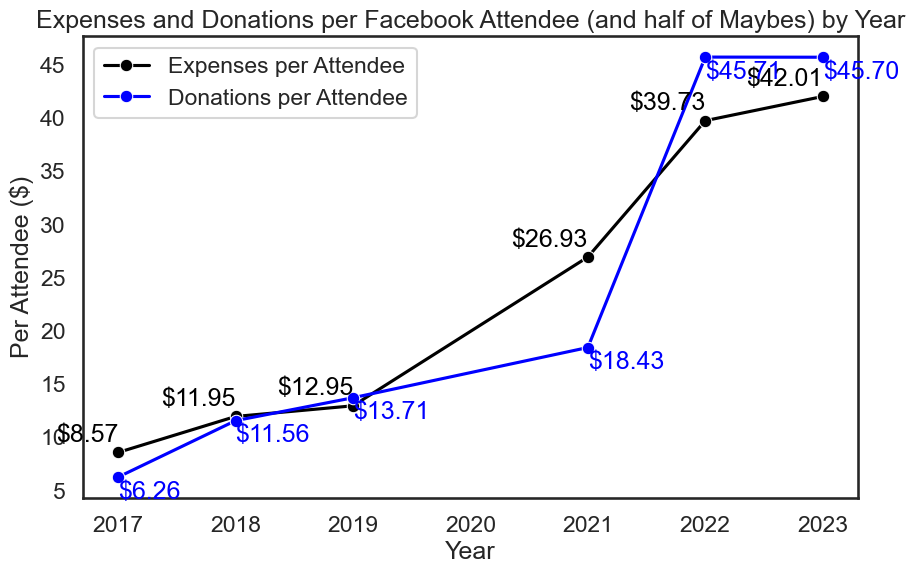

In [107]:
# plot of expenses per attendee by year

# group and sort sums by year
df_sum = df[df.Year >= 2017].groupby("Year")["Amount"].sum().reset_index()
att_sum = att_df[att_df.Year >= 2017].copy()

# merge dfs
df_sum = pd.merge(df_sum, att_sum, on="Year", how="outer")

# calculate expenses per attendee
df_sum["Expenses_per_attendee"] = df_sum["Amount"] / (
    df_sum["Going"] + df_sum["Maybes"] / 2
)

# merge don_df with df_sum
df_sum = pd.merge(df_sum, don_df, on="Year", how="outer")

# calculate donations per attendee
df_sum["Donations_per_attendee"] = df_sum["Donations"] / (
    df_sum["Going"] + df_sum["Maybes"] / 2
)

# plot and format line chart for expenses
sns.set_theme(style="white", context="talk")
plt.figure(figsize=(10, 6))
sns.lineplot(
    x="Year",
    y="Expenses_per_attendee",
    data=df_sum,
    marker="o",
    color="black",
    label="Expenses per Attendee",
)

# plot and format line chart for donations
sns.lineplot(
    x="Year",
    y="Donations_per_attendee",
    data=df_sum,
    marker="o",
    color="blue",
    label="Donations per Attendee",
)

# annotate each data point for expenses
for _, row in df_sum.iterrows():
    year = row.Year
    amount = row.Expenses_per_attendee
    plt.text(
        year, amount + 1, f"${amount:.2f}", horizontalalignment="right", color="black"
    )

# annotate each data point for donations
for _, row in df_sum.iterrows():
    year = row.Year
    donation = row.Donations_per_attendee
    plt.text(
        year, donation - 2, f"${donation:.2f}", horizontalalignment="left", color="blue"
    )

# format plot
plt.title("Expenses and Donations per Facebook Attendee (and half of Maybes) by Year")
plt.xlabel("Year")
plt.ylabel("Per Attendee ($)")
plt.show()

I suspect this is a reflection of inflation, the declining relevancy of Facebook invites as a useful metric in the 2020's, and escalating costs. Inflation's a bitch, nobody uses Facebook, and we purchase more goods / services (e.g., Cleaning, Logo). I tried two different versions (one just based on FB Going, the other based on FB attendees and half of FB Maybes).

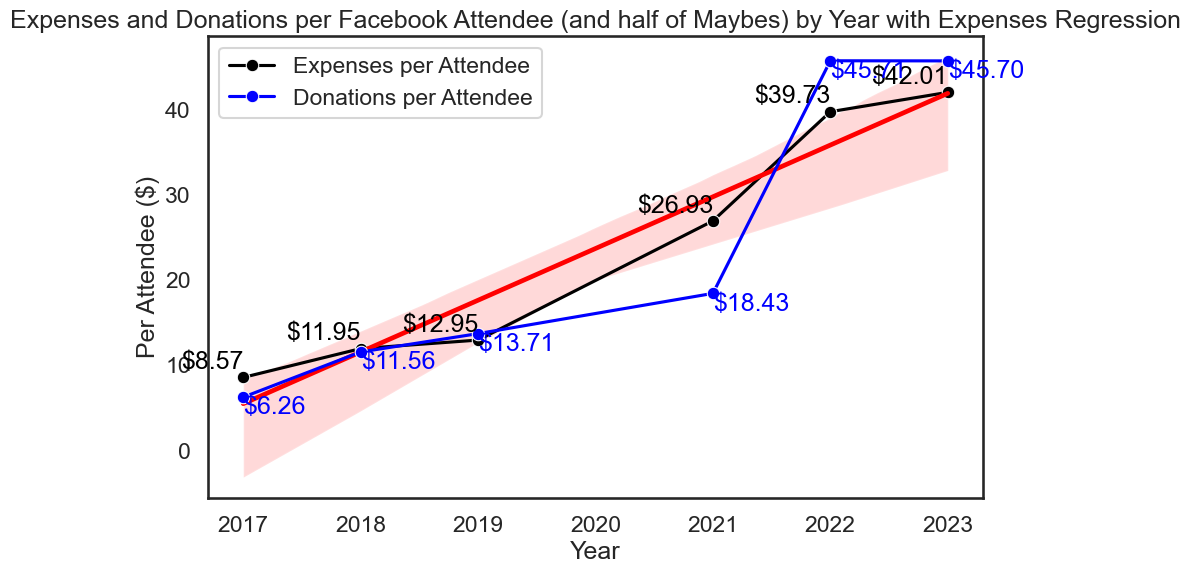

In [108]:
# plot of expenses per attendee by year

# group and sort sums by year
df_sum = df[df.Year >= 2017].groupby("Year")["Amount"].sum().reset_index()
att_sum = att_df[att_df.Year >= 2017].copy()

# merge dfs
df_sum = pd.merge(df_sum, att_sum, on="Year", how="outer")

# calculate expenses per attendee
df_sum["Expenses_per_attendee"] = df_sum["Amount"] / (
    df_sum["Going"] + df_sum["Maybes"] / 2
)

# merge don_df with df_sum
df_sum = pd.merge(df_sum, don_df, on="Year", how="outer")

# calculate donations per attendee
df_sum["Donations_per_attendee"] = df_sum["Donations"] / (
    df_sum["Going"] + df_sum["Maybes"] / 2
)

# plot and format line chart for expenses
sns.set_theme(style="white", context="talk")
plt.figure(figsize=(10, 6))
sns.lineplot(
    x="Year",
    y="Expenses_per_attendee",
    data=df_sum,
    marker="o",
    color="black",
    label="Expenses per Attendee",
)

# regression line for expenses
sns.regplot(
    x="Year", y="Expenses_per_attendee", data=df_sum, scatter=False, color="red"
)

# plot and format line chart for donations
sns.lineplot(
    x="Year",
    y="Donations_per_attendee",
    data=df_sum,
    marker="o",
    color="blue",
    label="Donations per Attendee",
)

# regression line for donations
# sns.regplot(x="Year", y="Donations_per_attendee", data=df_sum, scatter=False, color='blue')

# annotate each data point for expenses
for _, row in df_sum.iterrows():
    year = row.Year
    amount = row.Expenses_per_attendee
    plt.text(
        year, amount + 1, f"${amount:.2f}", horizontalalignment="right", color="black"
    )

# annotate each data point for donations
for _, row in df_sum.iterrows():
    year = row.Year
    donation = row.Donations_per_attendee
    plt.text(
        year, donation - 2, f"${donation:.2f}", horizontalalignment="left", color="blue"
    )

# format plot
plt.title(
    "Expenses and Donations per Facebook Attendee (and half of Maybes) by Year with Expenses Regression"
)
plt.xlabel("Year")
plt.ylabel("Per Attendee ($)")
plt.show()

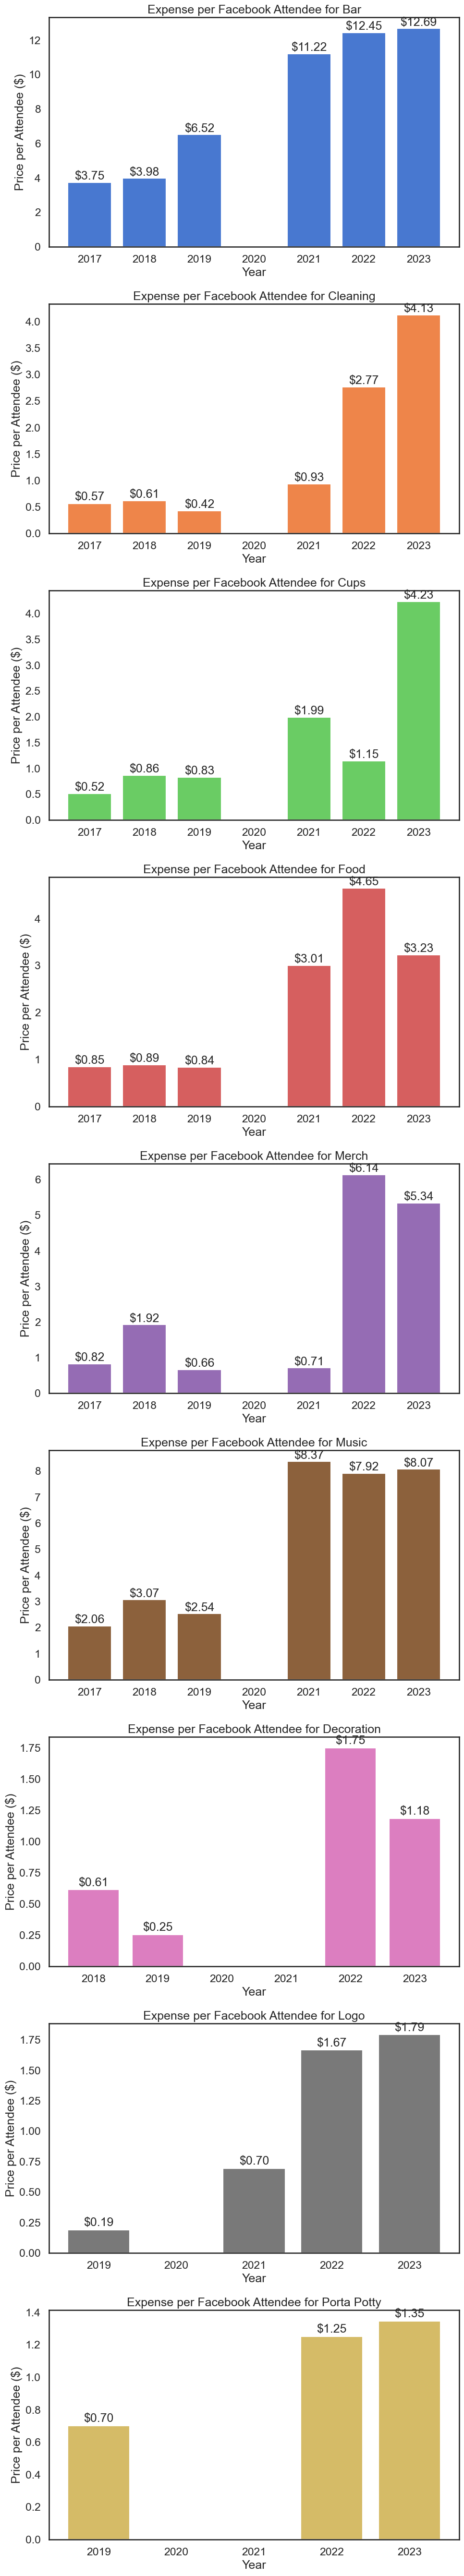

In [109]:
# plot price per attendee by year per category

# group and sort sums by Category and Year
df_cat_year_sum = df.groupby(["Category", "Year"]).sum().reset_index()

# merge att_df into df_cat_year_sum
df_cat_year_sum = pd.merge(df_cat_year_sum, att_df, on="Year")

# calculate price per attendee for each category-year combination
df_cat_year_sum["Price_per_attendee"] = df_cat_year_sum["Amount"] / (
    df_cat_year_sum["Going"] + df_cat_year_sum["Maybes"] / 2
)

# get unique categories
categories = df_cat_year_sum["Category"].unique()

# create subplots
fig, axs = plt.subplots(len(categories), 1, figsize=(10, 6 * len(categories)))

for i, category in enumerate(categories):
    # filter data for the current category
    df_category = df_cat_year_sum[df_cat_year_sum["Category"] == category]

    # plot the data
    bars = axs[i].bar(
        df_category["Year"],
        df_category["Price_per_attendee"],
        color=sns.color_palette("muted")[i],
    )

    # format plot
    axs[i].set_title("Expense per Facebook Attendee for {}".format(category))
    axs[i].set_xlabel("Year")
    axs[i].set_ylabel("Price per Attendee ($)")

    # annotate the bars
    for bar in bars:
        yval = bar.get_height()
        axs[i].text(
            bar.get_x() + bar.get_width() / 2,
            yval + 0.01,
            "${:,.2f}".format(yval),
            ha="center",
            va="bottom",
        )

plt.tight_layout()
plt.show()

## Bar

- [Back to Table of Contents](#table-of-contents)

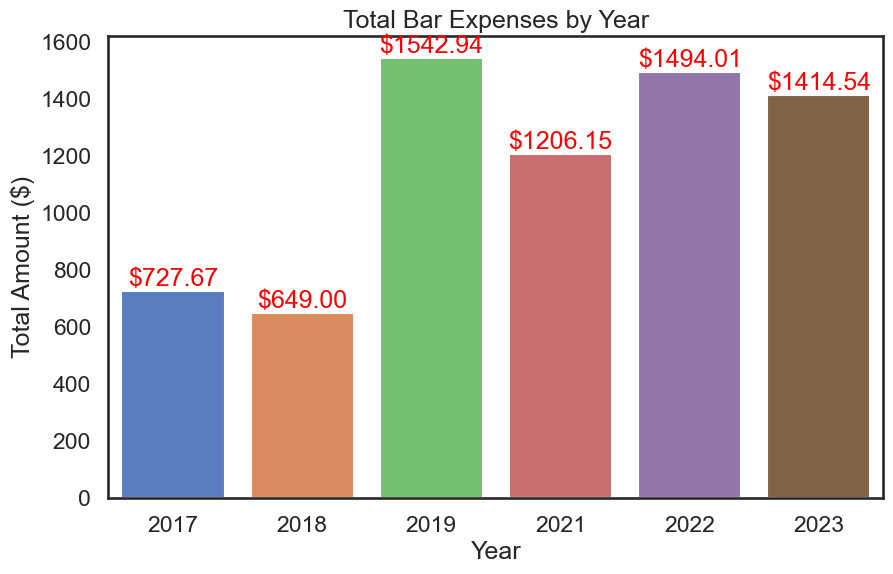

In [110]:
# bar expenses per year

# group and sort sums by Year
df_year_sum = df_bar_expenses.groupby("Year").sum().reset_index()

# plot the chart
sns.set_theme(style="white", context="talk")
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="Year", y="Amount", data=df_year_sum, palette="muted")

# add labels
for container in ax.containers:
    ax.bar_label(container, fmt="$%.2f", color="red")

# format plot
plt.title("Total Bar Expenses by Year")
plt.xlabel("Year")
plt.ylabel("Total Amount ($)")
plt.show()

In [111]:
# sum booze consumed by Packaging and Potable

# group by 'Packaging' and 'Potable' and sum 'Quantity'
df_bar = (
    alcohol_consumed_df.groupby(["Packaging", "Potable"])["Quantity"]
    .sum()
    .reset_index()
)

print(df_bar)

   Packaging                        Potable  Quantity
0        can                           beer    190.00
1     handle                       Fireball      8.00
2     handle                     Triple Sec      0.25
3     handle                            gin      2.00
4     handle                         liquor      1.00
5     handle                            rum      4.50
6     handle                        tequila      5.00
7     handle                          vodka     13.00
8     handle                        whiskey      9.00
9        keg             Bell's Two Hearted      0.50
10       keg                Bold Rock Cider      2.00
11       keg  Devil's Backbone Vienna Lager      3.00
12       keg                Eastcider's Dry      2.00
13       keg               Port City Porter      2.50
14    sixtel                   Blonde Stout      1.00
15    sixtel                  Christmas Ale      1.00
16    sixtel                          Cider      1.00
17    sixtel                

In [112]:
# sum number of drinks consumed by Packaging

# Group by 'Packaging' and sum 'Quantity'
df_bar_totals = alcohol_consumed_df.groupby("Packaging")["Quantity"].sum().reset_index()
print("Total alcohol consumed by Packaging:")
df_bar_totals

Total alcohol consumed by Packaging:


Packaging  Quantity
0       can    190.00
1    handle     42.75
2       keg     10.00
3    sixtel     47.50

In [113]:
# sum drinks consumed by Potable by year

# Group by 'Potable' and 'Year' and sum 'Quantity'
df_bar_totals = (
    alcohol_consumed_df.groupby(["Potable", "Year"])["Quantity"].sum().reset_index()
)

# sort values by Year
df_bar_totals = df_bar_totals.sort_values("Year")

print("Total alcohol consumed by Potable and Year:")
df_bar_totals

Total alcohol consumed by Potable and Year:


Potable  Year  Quantity
43                        tequila  2018      1.00
1                    Blonde Stout  2018      1.00
25               Port City Porter  2018      1.00
53                        whiskey  2018      2.00
22                         Kolsch  2018      6.00
8     DC Brau Wings of Armageddon  2018      1.00
48                          vodka  2018      2.00
38                            rum  2018      1.00
12                            ESB  2018      1.50
19                            IPA  2018      3.00
15                       Fireball  2018      2.00
33                           beer  2019    150.00
26               Port City Porter  2019      1.00
23                         Kolsch  2019      2.00
37                         liquor  2019      1.00
39                            rum  2019      1.00
28                          Rando  2019      1.00
44                        tequila  2019      1.00
49                          vodka  2019      3.00
6                       Cream Ale  2019      8.00
54                        whiskey  2019      2.00
2                 Bold Rock Cider  2019      1.00
16                       Fireball  2019      2.00
30                           Sour  2019      1.00
40                            rum  2021      1.00
31               Sour Berry Blast  2021      1.00
45                        tequila  2021      1.00
50                          vodka  2021      3.00
35                            gin  2021      1.00
55                        whiskey  2021      1.00
0              Bell's Two Hearted  2021      0.50
13                Eastcider's Dry  2021      1.00
4                   Christmas Ale  2021      1.00
27               Port City Porter  2021      0.50
9   Devil's Backbone Vienna Lager  2021      1.00
51                          vodka  2022      3.00
7                       Cream Ale  2022      6.00
10  Devil's Backbone Vienna Lager  2022      1.00
46                        tequila  2022      1.00
14                Eastcider's Dry  2022      1.00
41                            rum  2022      1.00
56                        whiskey  2022      2.00
20                            IPA  2022      3.00
36                            gin  2022      1.00
24                        Marzen?  2022      1.00
34                           beer  2022     40.00
17                       Fireball  2022      2.00
42                            rum  2023      0.50
18                       Fireball  2023      2.00
29                      Red Lager  2023      8.00
11  Devil's Backbone Vienna Lager  2023      1.00
47                        tequila  2023      1.00
21                            IPA  2023      2.00
52                          vodka  2023      2.00
5                           Cider  2023      1.00
32                     Triple Sec  2023      0.25
3                 Bold Rock Cider  2023      1.00
57                        whiskey  2023      2.00

In [114]:
# sum drinks consumed by Packaging and year, convert to ounces

# Group by 'Potable' and 'Year' and sum 'Quantity'
df_bar_totals = (
    alcohol_consumed_df.groupby(["Packaging", "Year"])["Ounces"].sum().reset_index()
)

# sort values by Year
df_bar_totals = df_bar_totals.sort_values("Year")

print("Total ounces of alcohol consumed by Packaging and Year:")
df_bar_totals

Total ounces of alcohol consumed by Packaging and Year:


Packaging  Year   Ounces
2     handle  2018   472.00
12    sixtel  2018  8262.50
7        keg  2018  1984.00
0        can  2019  1800.00
13    sixtel  2019  7932.00
8        keg  2019  3968.00
3     handle  2019   590.00
4     handle  2021   413.00
9        keg  2021  5952.00
14    sixtel  2021  1322.00
15    sixtel  2022  6610.00
10       keg  2022  3968.00
1        can  2022   480.00
5     handle  2022   590.00
6     handle  2023   457.25
11       keg  2023  3968.00
16    sixtel  2023  7271.00

In [115]:
# group by 'Packaging' and 'Potable' and sum 'Quantity'
df_bar = (
    alcohol_consumed_df.groupby(["Packaging", "Potable"])["Quantity"]
    .sum()
    .reset_index()
)

print(df_bar)

   Packaging                        Potable  Quantity
0        can                           beer    190.00
1     handle                       Fireball      8.00
2     handle                     Triple Sec      0.25
3     handle                            gin      2.00
4     handle                         liquor      1.00
5     handle                            rum      4.50
6     handle                        tequila      5.00
7     handle                          vodka     13.00
8     handle                        whiskey      9.00
9        keg             Bell's Two Hearted      0.50
10       keg                Bold Rock Cider      2.00
11       keg  Devil's Backbone Vienna Lager      3.00
12       keg                Eastcider's Dry      2.00
13       keg               Port City Porter      2.50
14    sixtel                   Blonde Stout      1.00
15    sixtel                  Christmas Ale      1.00
16    sixtel                          Cider      1.00
17    sixtel                

In [116]:
# sum ounces by Packaging

# group by 'Packaging' and sum 'Ounces'
df_bar_totals = df_bar.groupby("Packaging")["Ounces"].sum().reset_index()
print("Total alcohol consumed by Packaging in Ounces:")
df_bar_totals

KeyError: 'Column not found: Ounces'

In [ ]:
# # group by 'Packaging' and sum 'Ounces'
df_bar_totals = df_bar.groupby("Packaging")["Ounces"].sum().reset_index()

# replace all 'Packaging' values that are not 'handle' with 'other'
df_bar_totals["Packaging"] = (
    df_bar_totals["Packaging"]
    .replace(["can", "keg", "sixtel"], "beer")
    .replace("handle", "liquor")
)

# sum ounces by Packaging
df_bar_totals = df_bar_totals.groupby("Packaging")["Ounces"].sum().reset_index()

print("Total alcohol consumed by Packaging in Ounces:")
df_bar_totals

Total alcohol consumed by Packaging in Ounces:


Packaging    Ounces
0      beer  53517.50
1    liquor   2522.25

## <center>alcohol_year_type_df</center>

In [ ]:
# sum drinks consumed by Packaging and year, combine beer, convert to ounces

# group by 'Potable' and 'Year' and sum 'Quantity'
df_bar_totals = (
    alcohol_consumed_df.groupby(["Packaging", "Year"])["Quantity"].sum().reset_index()
)

# convert df_bar to ounces
df_bar_totals["Quantity"] = df_bar_totals.apply(convert_to_ounces, axis=1)

# rename 'Quantity' column to 'Ounces'
df_bar_totals.rename(columns={"Quantity": "Ounces"}, inplace=True)

# replace all 'Packaging' values that are not 'handle' with 'other'
df_bar_totals["Packaging"] = (
    df_bar_totals["Packaging"]
    .replace(["can", "keg", "sixtel"], "beer")
    .replace("handle", "liquor")
)

# group by 'Packaging' and 'Year' and sum 'Ounces'
df_bar_totals = (
    df_bar_totals.groupby(["Packaging", "Year"])["Ounces"].sum().reset_index()
)

# sort values by Year
df_bar_totals = df_bar_totals.sort_values("Year")

# save df_bar_totals for use is EDA
alcohol_year_type_df = df_bar_totals.reset_index(drop=True)

print("Total alcohol consumed by Packaging in Ounces:")
alcohol_year_type_df

Total alcohol consumed by Packaging in Ounces:


Packaging  Year    Ounces
0      beer  2018  10246.50
1    liquor  2018    472.00
2      beer  2019  13700.00
3    liquor  2019    590.00
4      beer  2021   7274.00
5    liquor  2021    413.00
6      beer  2022  11058.00
7    liquor  2022    590.00
8      beer  2023  11239.00
9    liquor  2023    457.25

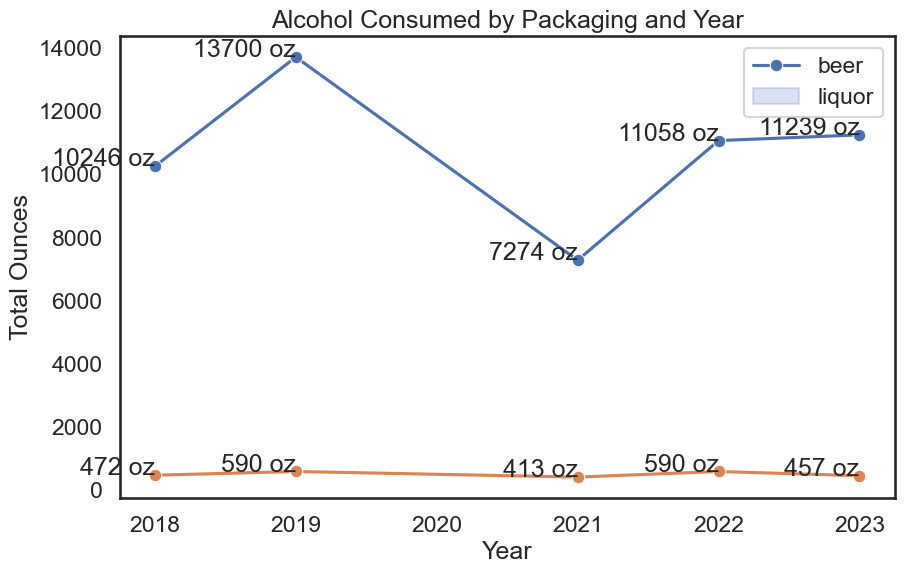

In [ ]:
# line chart of alcohol_year_df, one line per type of alcohol, per year, annotated with ounces

# plot the chart
sns.set_theme(style="white", context="talk")
plt.figure(figsize=(10, 6))
for potable in alcohol_year_type_df.Packaging.unique():
    sns.lineplot(
        x="Year",
        y="Ounces",
        data=alcohol_year_type_df[alcohol_year_type_df.Packaging == potable],
        marker="o",
    )

# annotate each data point
for _, row in alcohol_year_type_df.iterrows():
    year = row.Year
    ounces = row.Ounces
    plt.text(year, ounces, f"{ounces:.0f} oz", horizontalalignment="right")

# format plot
plt.title("Alcohol Consumed by Packaging and Year")
plt.xlabel("Year")
plt.ylabel("Total Ounces")
plt.legend(alcohol_year_type_df.Packaging.unique())
plt.show()

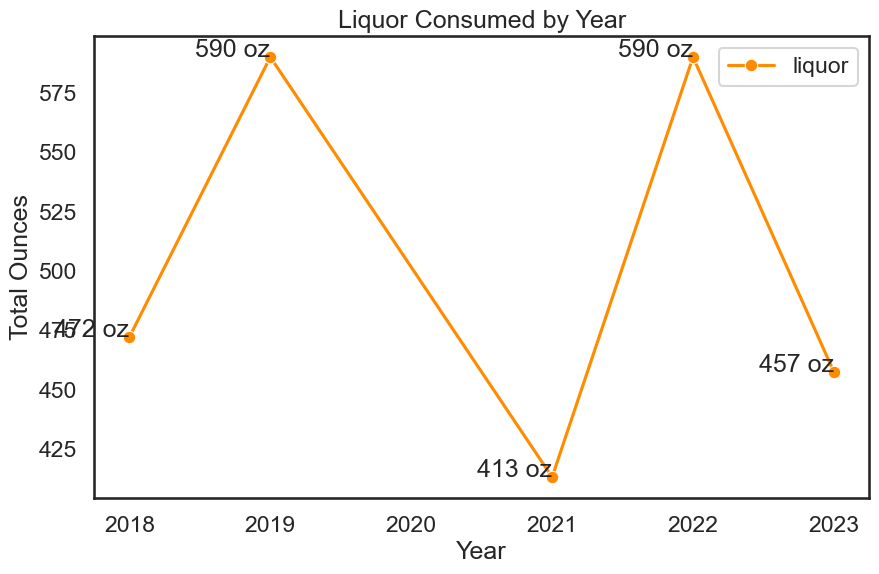

In [ ]:
# line chart of liquor per year, annotated with ounces

# plot the chart
sns.set_theme(style="white", context="talk")
plt.figure(figsize=(10, 6))

# Filter the DataFrame for 'Packaging' == 'liquor'
liquor_df = alcohol_year_type_df[alcohol_year_type_df.Packaging == "liquor"]

sns.lineplot(
    x="Year",
    y="Ounces",
    data=liquor_df,
    marker="o",
    color="darkorange",
)

# annotate each data point
for _, row in liquor_df.iterrows():
    year = row.Year
    ounces = row.Ounces
    plt.text(year, ounces, f"{ounces:.0f} oz", horizontalalignment="right")

# format plot
plt.title("Liquor Consumed by Year")
plt.xlabel("Year")
plt.ylabel("Total Ounces")
plt.legend(liquor_df.Packaging.unique())
plt.show()

# Problems!! 

I need to split beer and liquor in expenses. This is getting increasingly assumption laden. I should probably then evaluate that on ABV, but... I weary of this task

posx and posy should be finite values
posx and posy should be finite values


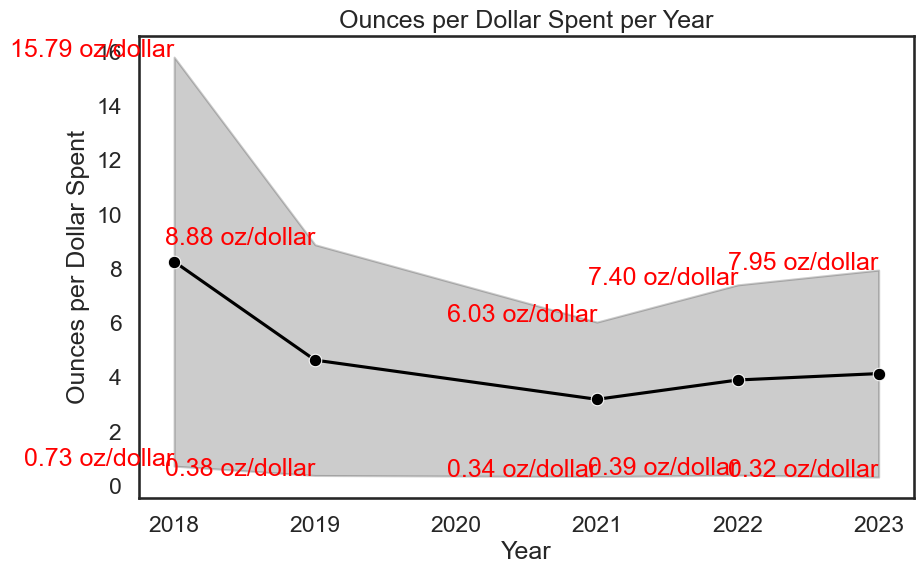

In [ ]:
# line plot of ounces per sum of 'Amount' for df's Category = 'Bar' by year

# group and sort sums by Year
df_year_sum = df_bar_expenses.groupby("Year").sum().reset_index()

# merge df_year_sum with alcohol_year_type_df
df_year_sum = pd.merge(df_year_sum, alcohol_year_type_df, on="Year", how="outer")

# calculate ounces per sum of 'Amount'
df_year_sum["Ounces_per_Amount"] = df_year_sum["Ounces"] / df_year_sum["Amount"]

# plot the chart
sns.set_theme(style="white", context="talk")
plt.figure(figsize=(10, 6))
sns.lineplot(
    x="Year",
    y="Ounces_per_Amount",
    data=df_year_sum,
    marker="o",
    color="black",
)

# annotate each data point
for _, row in df_year_sum.iterrows():
    year = row.Year
    ounces = row.Ounces_per_Amount
    plt.text(
        year,
        ounces,
        f"{ounces:.2f} oz/dollar",
        horizontalalignment="right",
        color="red",
    )

# format plot
plt.title("Ounces per Dollar Spent per Year")
plt.xlabel("Year")
plt.ylabel("Ounces per Dollar Spent")
plt.show()

posx and posy should be finite values
posx and posy should be finite values


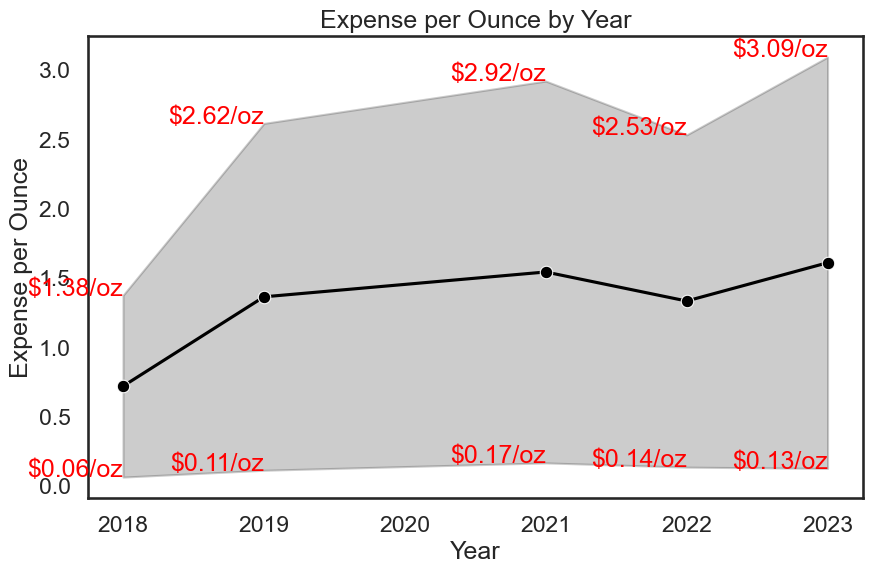

In [ ]:
# line plot of ounces per sum of 'Amount' for df's Category = 'Bar' by year

# group and sort sums by Year
df_year_sum = df_bar_expenses.groupby("Year").sum().reset_index()

# merge df_year_sum with alcohol_year_type_df
df_year_sum = pd.merge(df_year_sum, alcohol_year_type_df, on="Year", how="outer")

# calculate ounces per sum of 'Amount'
df_year_sum["Expense per Ounce"] = df_year_sum["Amount"] / df_year_sum["Ounces"]

# plot the chart
sns.set_theme(style="white", context="talk")
plt.figure(figsize=(10, 6))
sns.lineplot(
    x="Year",
    y="Expense per Ounce",
    data=df_year_sum,
    marker="o",
    color="black",
)

# annotate each data point
for _, row in df_year_sum.iterrows():
    year = row.Year
    cost = row["Expense per Ounce"]
    plt.text(year, cost, f"${cost:.2f}/oz", horizontalalignment="right", color="red")

# format plot
plt.title("Expense per Ounce by Year")
plt.xlabel("Year")
plt.ylabel("Expense per Ounce")
plt.show()

   Year       Amount    Ounces  Expense_to_Alcohol_Ratio
0  2018   649.000000  10718.50                  0.060550
1  2019  1542.943333  14290.00                  0.107974
2  2021  1206.153333   7687.00                  0.156908
3  2022  1494.013333  11648.00                  0.128264
4  2023  1414.536667  11696.25                  0.120939


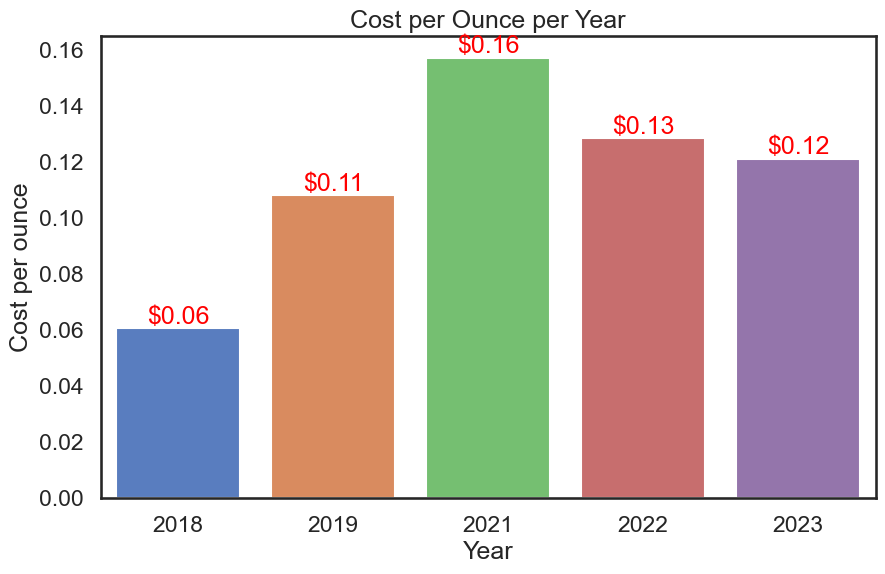

In [ ]:
# Calculate the sum of bar expenses per year
bar_expenses_sum = df_bar_expenses.groupby("Year")["Amount"].sum().reset_index()

# Calculate the sum of total ounces of alcohol per year
alcohol_ounces_sum = alcohol_year_type_df.groupby("Year")["Ounces"].sum().reset_index()

# Merge the two data frames on 'Year'
merged_df = pd.merge(bar_expenses_sum, alcohol_ounces_sum, on="Year")

# Calculate the ratio of bar expenses to total alcohol ounces
merged_df["Expense_to_Alcohol_Ratio"] = merged_df["Amount"] / merged_df["Ounces"]

print(merged_df)

# Bar Plot for the ratio
sns.set_theme(style="white", context="talk")
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x="Year", y="Expense_to_Alcohol_Ratio", data=merged_df, palette="muted"
)

# Annotate each bar with the cost
for container in ax.containers:
    ax.bar_label(container, fmt="$%.2f", color="red")

plt.xlabel("Year")
plt.ylabel("Cost per ounce")
plt.title("Cost per Ounce per Year")
plt.show()

posx and posy should be finite values
posx and posy should be finite values


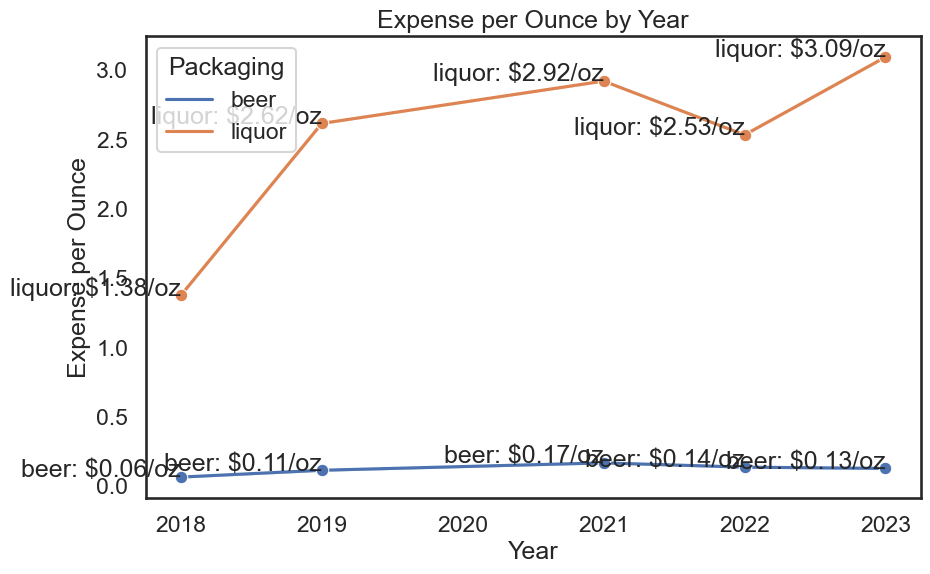

In [ ]:
# Merge df_bar_expenses with alcohol_year_type_df
df_merged = pd.merge(df_bar_expenses, alcohol_year_type_df, on="Year", how="outer")

# Calculate ounces per sum of 'Amount' for each type of alcohol
df_merged["Expense per Ounce"] = (
    df_merged.groupby(["Year", "Packaging"])["Amount"].transform("sum")
    / df_merged["Ounces"]
)

# Plot the chart
sns.set_theme(style="white", context="talk")
plt.figure(figsize=(10, 6))
sns.lineplot(
    x="Year",
    y="Expense per Ounce",
    hue="Packaging",
    data=df_merged,
    marker="o",
)

# Annotate each data point
for _, row in df_merged.drop_duplicates(["Year", "Packaging"]).iterrows():
    year = row.Year
    cost = row["Expense per Ounce"]
    packaging = row.Packaging
    plt.text(year, cost, f"{packaging}: ${cost:.2f}/oz", horizontalalignment="right")

# Format plot
plt.title("Expense per Ounce by Year")
plt.xlabel("Year")
plt.ylabel("Expense per Ounce")
plt.legend(title="Packaging")
plt.show()

## Sub-categories
Individual Expenses for each year

- [Back to Table of Contents](#table-of-contents)

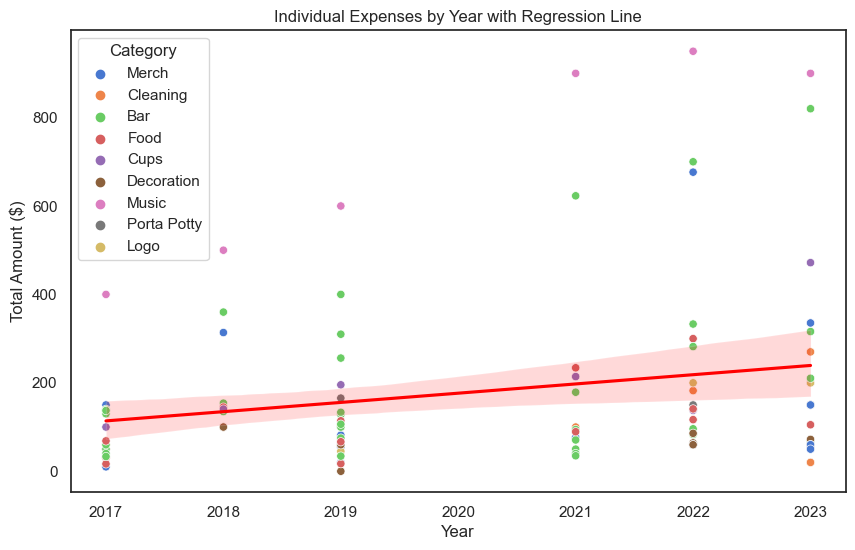

In [ ]:
# scatter plot of expenses per year, color-coded by category

# plot the chart
sns.set_theme(style="white")
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(x="Year", y="Amount", hue="Category", data=df, palette="muted")

# regression line
sns.regplot(x="Year", y="Amount", data=df, scatter=False, color="red")

# format plot
plt.title("Individual Expenses by Year with Regression Line")
plt.xlabel("Year")
plt.ylabel("Total Amount ($)")
plt.legend(title="Category")
plt.show()

In [ ]:
# scatter plot of expenses per year, color-coded by category

# create the scatter plot
fig = px.scatter(
    df,
    x="Year",
    y="Amount",
    color="Category",
    hover_data=["Expense", "Amount", "Year", "Name"],
)

# format plot
fig.update_layout(
    title="Individual Expenses by Year (Hover for more info)",
    xaxis_title="Year",
    yaxis_title="Total Amount ($)",
    legend_title="Category",
)

# show the plot
fig.show()

In [ ]:
# scatter plot of expenses per year, color-coded by category

# create the scatter plot with a regression line
fig = px.scatter(
    df,
    x="Year",
    y="Amount",
    color="Category",
    hover_data=["Expense", "Amount", "Year", "Name"],
    trendline="ols",  # add a regression line
)

# format plot
fig.update_layout(
    title="Individual Expenses by Year with Regression Lines (Hover for more info)",
    xaxis_title="Year",
    yaxis_title="Total Amount ($)",
    legend_title="Category",
)

# show the plot
fig.show()

In [ ]:
# bar plot of each year's expenses

# get unique years and categories
years = df["Year"].unique()
categories = df["Category"].unique()

# create a color dictionary
color_discrete_map = {
    category: px.colors.qualitative.Plotly[i % len(px.colors.qualitative.Plotly)]
    for i, category in enumerate(categories)
}

# create a subplot for each year
for year in years:
    df_year = df[df["Year"] == year]

    # sort by Amount
    df_year = df_year.sort_values("Amount")

    # create the bar chart
    fig = px.bar(
        df_year,
        x="Expense",
        y="Amount",
        color="Category",
        hover_data={"Expense": True, "Amount": False, "Name": True},
        labels={"Expense": "Expense", "Amount": "Amount ($)", "Name": "Name"},
        title=f"Expenses for {year} (Hover for more info)",
        text=df_year["Amount"].apply(lambda x: f"${x:.2f}"),
        color_discrete_map=color_discrete_map,
    )

    # hide x-axis labels
    fig.update_xaxes(visible=False, showticklabels=False)

    # update text on bars and customize hover text
    fig.update_traces(textposition="outside", hovertemplate="<b>%{x}</b><br>%{text}")

    fig.show()

The columns with split values are Costco Expenses.

In [ ]:
# plot a sunburst chart, with categories on the inside and expense on the outside
# add a hover over expense, to include the Expense and Amount

# unique id for each expense
df_copy = df.copy()
df_copy.reset_index(inplace=True)

# group and sort sums by Category and Name
df_cat_name_sum = df_copy.groupby(["Category", "Expense", "index"]).sum().reset_index()
df_cat_name_sum = df_cat_name_sum.sort_values("Amount", ascending=False)

# plot the chart
fig = px.sunburst(
    df_cat_name_sum,
    path=["Category", "Year", "Expense"],
    values="Amount",
    title="Total Expenses by Category and Person (Hover for more info)",
    hover_data=["Name", "Year"],
)

# update layout for better display
fig.update_layout(
    height=600,
    width=800,
    uniformtext=dict(minsize=12, mode="hide"),
)

# hover data
fig.update_traces(
    hovertemplate="<b>%{label}</b>: $%{value:.2f}<br><b>Name:</b> %{customdata[0]}<br><b>Year:</b> %{customdata[1]}"
)


fig.show()

## Appendix (Tables)

- [Back to Table of Contents](#table-of-contents)

In [ ]:
# list expenses in order of highest to lowest

# sort by Amount
df_sorted = df.sort_values("Amount", ascending=False)

# format Amount as currency
df_sorted.Amount = df_sorted.Amount.apply(lambda x: f"${x:.2f}")

# create a table
fig = go.Figure(
    data=[
        go.Table(
            header=dict(
                values=["Expense", "Amount", "Name", "Year", "Category"],
                fill_color="paleturquoise",
                align="left",
            ),
            cells=dict(
                values=[
                    df_sorted.Expense,
                    df_sorted.Amount,
                    df_sorted.Name,
                    df_sorted.Year,
                    df_sorted.Category,
                ],
                fill_color="lavender",
                align="left",
            ),
        )
    ]
)

# format table
fig.update_layout(title="Expenses from Highest to Lowest", height=600, width=800)

fig.show()

In [ ]:
# table for max expenses

# get max Amount per Category
max_amount_rows = df.loc[df.groupby("Category")["Amount"].idxmax()]

# sort values
max_amount_rows = max_amount_rows.sort_values("Amount", ascending=False)

# format Amount as currency
max_amount_rows["Amount"] = max_amount_rows["Amount"].apply(lambda x: f"${x:.2f}")

fig_max = go.Figure(
    data=[
        go.Table(
            header=dict(
                values=["Category", "Max Amount", "Year", "Expense"],
                fill_color="paleturquoise",
                align="left",
            ),
            cells=dict(
                values=[
                    max_amount_rows.Category,
                    max_amount_rows.Amount,
                    max_amount_rows.Year,
                    max_amount_rows.Expense,
                ],
                fill_color="lavender",
                align="left",
            ),
        )
    ]
)

# format table
fig_max.update_layout(title="Maximum Expenses by Category")

fig_max.show()

In [ ]:
# table for min expenses

# get min Amount per Category
# there's a zero value for Decoration in 2019 (pumpkins / hay)
min_amount_rows = df[df["Amount"] != 0].loc[
    df[df["Amount"] != 0].groupby("Category")["Amount"].idxmin()
]

# sort values
min_amount_rows = min_amount_rows.sort_values("Amount")

# format Amount as currency
min_amount_rows["Amount"] = min_amount_rows["Amount"].apply(lambda x: f"${x:.2f}")

fig_min = go.Figure(
    data=[
        go.Table(
            header=dict(
                values=["Category", "Min Amount", "Year", "Expense"],
                fill_color="paleturquoise",
                align="left",
            ),
            cells=dict(
                values=[
                    min_amount_rows.Category,
                    min_amount_rows.Amount,
                    min_amount_rows.Year,
                    min_amount_rows.Expense,
                ],
                fill_color="lavender",
                align="left",
            ),
        )
    ]
)

# format table
fig_min.update_layout(title="Minimum Expense by Category")

fig_min.show()

Most Max expenses are from 2022 and 2023. Not surprising.

In [ ]:
# average Amount per Category

# calculate average Amount by Category, sort values
avg_amount = df.groupby("Category")["Amount"].mean()
avg_amount = avg_amount.sort_values(ascending=False)

# format as currency
avg_amount = avg_amount.apply(lambda x: f"${x:.2f}")

# create table
fig = go.Figure(
    data=[
        go.Table(
            header=dict(
                values=["Category", "Average Amount"],
                fill_color="paleturquoise",
                align="left",
            ),
            cells=dict(
                values=[
                    avg_amount.index,
                    avg_amount.values,
                ],
                fill_color="lavender",
                align="left",
            ),
        )
    ]
)

# format table
fig.update_layout(title="Mean (Average) Expense (Sub-Category) per Category")

fig.show()

I don't think the 'Mean (Average) Expense (Sub-Category) per Category' really tells us anything. Totals matter more.

In [ ]:
# Calculate sum of Amount by Category, sort values
sum_amount = df.groupby("Category")["Amount"].sum()

# Calculate total entries per Category
total_entries = df.groupby("Category")["Amount"].count()

# Create a new DataFrame
df_category = pd.DataFrame(
    {"Total Expenses": sum_amount, "Total Entries": total_entries}
)

# Sort the DataFrame by Total Expenses
df_category.sort_values(by="Total Expenses", ascending=False, inplace=True)

# Format Total Expenses as currency
df_category["Total Expenses"] = df_category["Total Expenses"].apply(
    lambda x: f"${x:.2f}"
)

# Create a table
fig = go.Figure(
    data=[
        go.Table(
            header=dict(
                values=["Category", "Total Expenses", "Total Entries"],
                fill_color="paleturquoise",
                align="left",
            ),
            cells=dict(
                values=[
                    df_category.index,
                    df_category["Total Expenses"],
                    df_category["Total Entries"],
                ],
                fill_color="lavender",
                align="left",
            ),
        )
    ]
)

# Format table
fig.update_layout(title="Total Expenses and Entries (All Time) per Category")

fig.show()

In [ ]:
# calculate total expenses per Year
total_expenses = df.groupby("Year")["Amount"].sum().sort_values(ascending=False)
total_expenses = total_expenses.apply(lambda x: f"${x:.2f}")

# calculate total entries per Year
total_entries = df.groupby("Year")["Amount"].count()

# new df
df_yearly = pd.DataFrame(
    {"Total Expenses": total_expenses, "Total Entries": total_entries}
)

# sort by Total Expenses
df_yearly.sort_values(by="Total Expenses", ascending=False, inplace=True)

fig = go.Figure(
    data=[
        go.Table(
            header=dict(
                values=["Year", "Total Expenses", "Total Entries"],
                fill_color="paleturquoise",
                align="left",
            ),
            cells=dict(
                values=[
                    df_yearly.index,
                    df_yearly["Total Expenses"],
                    df_yearly["Total Entries"],
                ],
                fill_color="lavender",
                align="left",
            ),
        )
    ]
)

# format table
fig.update_layout(title="Expenses and Entries by Year")

fig.show()

In [ ]:
# Expenses and entries by Name

# calculate total expenses by Name
total_expenses = df.groupby("Name")["Amount"].sum()

# calculate total entries per Name
total_entries = df.groupby("Name")["Amount"].count()

# new df
df_name = pd.DataFrame(
    {"Total Expenses": total_expenses, "Total Entries": total_entries}
)

# sort df
df_name.sort_values(by="Total Expenses", ascending=False, inplace=True)

# format currency
df_name["Total Expenses"] = df_name["Total Expenses"].apply(lambda x: f"${x:.2f}")

fig = go.Figure(
    data=[
        go.Table(
            header=dict(
                values=["Name", "Total Expenses", "Total Entries"],
                fill_color="paleturquoise",
                align="left",
            ),
            cells=dict(
                values=[
                    df_name.index,
                    df_name["Total Expenses"],
                    df_name["Total Entries"],
                ],
                fill_color="lavender",
                align="left",
            ),
        )
    ]
)

# format table
fig.update_layout(title="Expenses and Entries by Name")

fig.show()

In [ ]:
# Amount spent by Category and Year

# calculate total expenses by Category and Year
total_expenses = df.groupby(["Category", "Year"])["Amount"].sum()

# new df
df_category_year = pd.DataFrame(
    {
        "Total Expenses": total_expenses,
    }
)

# sort by Total Expenses
df_category_year.sort_values(by="Total Expenses", ascending=False, inplace=True)

# format as currency
df_category_year["Total Expenses"] = df_category_year["Total Expenses"].apply(
    lambda x: f"${x:.2f}"
)

# reset index to separate Category and Year
df_category_year.reset_index(inplace=True)

fig = go.Figure(
    data=[
        go.Table(
            header=dict(
                values=["Category", "Year", "Total Expenses"],
                fill_color="paleturquoise",
                align="left",
            ),
            cells=dict(
                values=[
                    df_category_year["Category"],
                    df_category_year["Year"],
                    df_category_year["Total Expenses"],
                ],
                fill_color="lavender",
                align="left",
            ),
        )
    ]
)

# format table
fig.update_layout(title="Total Expenses by Category per Year")

fig.show()

In [ ]:
# Amount spent by Category per Name

# calculate total expenses by Category and Name
total_expenses = df.groupby(["Category", "Name"])["Amount"].sum()

# new df
df_category_name = pd.DataFrame(
    {
        "Total Expenses": total_expenses,
    }
)

# sort by Total Expenses
df_category_name.sort_values(by="Total Expenses", ascending=False, inplace=True)

# format Total Expenses as currency
df_category_name["Total Expenses"] = df_category_name["Total Expenses"].apply(
    lambda x: f"${x:.2f}"
)

# reset index to separate Category and Name
df_category_name.reset_index(inplace=True)

fig = go.Figure(
    data=[
        go.Table(
            header=dict(
                values=["Category", "Name", "Total Expenses"],
                fill_color="paleturquoise",
                align="left",
            ),
            cells=dict(
                values=[
                    df_category_name["Category"],
                    df_category_name["Name"],
                    df_category_name["Total Expenses"],
                ],
                fill_color="lavender",
                align="left",
            ),
        )
    ]
)

# format table
fig.update_layout(title="Total Expenses by Category per Name")

fig.show()

In [ ]:
# Amount spent by Category per Name

# calculate total expenses by Category and Name
total_expenses = df.groupby(["Category", "Name"])["Amount"].sum()

# new df
df_category_name = pd.DataFrame(
    {
        "Total Expenses": total_expenses,
    }
)

# sort by Total Expenses
df_category_name.sort_values(by="Total Expenses", ascending=False, inplace=True)

# format as currency
df_category_name["Total Expenses"] = df_category_name["Total Expenses"].apply(
    lambda x: f"${x:.2f}"
)

# reset index to separate Category and Name
df_category_name.reset_index(inplace=True)

fig = go.Figure(
    data=[
        go.Table(
            header=dict(
                values=["Category", "Name", "Total Expenses"],
                fill_color="paleturquoise",
                align="left",
            ),
            cells=dict(
                values=[
                    df_category_name["Category"],
                    df_category_name["Name"],
                    df_category_name["Total Expenses"],
                ],
                fill_color="lavender",
                align="left",
            ),
        )
    ]
)

# format table
fig.update_layout(title="Total Expenses by Category per Name")

fig.show()

In [ ]:
# Amount spent by Name per Year

# calculate total expenses by Name and Year
total_expenses = df.groupby(["Name", "Year"])["Amount"].sum()

# new df
df_name_year = pd.DataFrame(
    {
        "Total Expenses": total_expenses,
    }
)

# sort by Total Expenses
df_name_year.sort_values(by="Total Expenses", ascending=False, inplace=True)

# format as currency
df_name_year["Total Expenses"] = df_name_year["Total Expenses"].apply(
    lambda x: f"${x:.2f}"
)

# reset index to separate Name and Year
df_name_year.reset_index(inplace=True)

fig = go.Figure(
    data=[
        go.Table(
            header=dict(
                values=["Name", "Year", "Total Expenses"],
                fill_color="paleturquoise",
                align="left",
            ),
            cells=dict(
                values=[
                    df_name_year["Name"],
                    df_name_year["Year"],
                    df_name_year["Total Expenses"],
                ],
                fill_color="lavender",
                align="left",
            ),
        )
    ]
)

# format table
fig.update_layout(title="Total Expenses by Name per Year")

fig.show()

In [ ]:
# Expenses sorted from highest to lowest by Name

# calculate total expenses by Name, Year, and Expense
top_expenses = df.groupby(["Name", "Year", "Expense"])["Amount"].sum()

# new df
df_name_year_expense = pd.DataFrame(
    {
        "Amount": top_expenses,
    }
)

# sort by AMount
df_name_year_expense.sort_values(by="Amount", ascending=False, inplace=True)

# format as currency
df_name_year_expense["Amount"] = df_name_year_expense["Amount"].apply(
    lambda x: f"${x:.2f}"
)

# reset index to separate Name, Year, and Expense
df_name_year_expense.reset_index(inplace=True)

fig = go.Figure(
    data=[
        go.Table(
            header=dict(
                values=["Name", "Year", "Expense", "Amount"],
                fill_color="paleturquoise",
                align="left",
            ),
            cells=dict(
                values=[
                    df_name_year_expense["Name"],
                    df_name_year_expense["Year"],
                    df_name_year_expense["Expense"],
                    df_name_year_expense["Amount"],
                ],
                fill_color="lavender",
                align="left",
            ),
        )
    ]
)

# format table
fig.update_layout(title="Top Expenses by Name, Year, and Expense")

fig.show()

In [ ]:
# Top Expenses by Category, Year, and Expense

# calculate total expenses by Category, Year, and Expense
top_expenses = df.groupby(["Category", "Year", "Expense"])["Amount"].sum()

# new df
df_category_year_expense = pd.DataFrame(
    {
        "Amount": top_expenses,
    }
)

# sort by Total Expenses
df_category_year_expense.sort_values(by="Amount", ascending=False, inplace=True)

# format as currency
df_category_year_expense["Amount"] = df_category_year_expense["Amount"].apply(
    lambda x: f"${x:.2f}"
)

# reset index to separate Category, Year, and Expense
df_category_year_expense.reset_index(inplace=True)

fig = go.Figure(
    data=[
        go.Table(
            header=dict(
                values=["Category", "Year", "Expense", "Amount"],
                fill_color="paleturquoise",
                align="left",
            ),
            cells=dict(
                values=[
                    df_category_year_expense["Category"],
                    df_category_year_expense["Year"],
                    df_category_year_expense["Expense"],
                    df_category_year_expense["Amount"],
                ],
                fill_color="lavender",
                align="left",
            ),
        )
    ]
)

# format table
fig.update_layout(title="Top Expenses by Category, Year, and Expense")

fig.show()

In [ ]:
# Total Expense by Category per Name and Year

# calculate total expenses by Category, Name, and Year
total_expenses = df.groupby(["Category", "Name", "Year"])["Amount"].sum()

# new df
df_category_name_year = pd.DataFrame(
    {
        "Total Expenses": total_expenses,
    }
)

# sort by Total Expenses
df_category_name_year.sort_values(by="Total Expenses", ascending=False, inplace=True)

# format as currency
df_category_name_year["Total Expenses"] = df_category_name_year["Total Expenses"].apply(
    lambda x: f"${x:.2f}"
)

# reset index to separate Category, Name, and Year
df_category_name_year.reset_index(inplace=True)

fig = go.Figure(
    data=[
        go.Table(
            header=dict(
                values=["Category", "Name", "Year", "Total Expenses"],
                fill_color="paleturquoise",
                align="left",
            ),
            cells=dict(
                values=[
                    df_category_name_year["Category"],
                    df_category_name_year["Name"],
                    df_category_name_year["Year"],
                    df_category_name_year["Total Expenses"],
                ],
                fill_color="lavender",
                align="left",
            ),
        )
    ]
)

# format table
fig.update_layout(title="Total Expenses by Category, Name, and Year")

fig.show()

In [ ]:
# T-shirts

# convert 'Expense' column to lowercase and check if it contains 'shirts'
mask = df["Expense"].str.lower().str.contains("shirts")

# new df where 'shirts' is in the 'Expense' column
df_shirts = df[mask]

# calculate total amount for 'shirts'
total_amount = df_shirts["Amount"].sum()

fig = go.Figure(
    data=[
        go.Table(
            header=dict(
                values=list(df_shirts.columns) + ["Total Amount"],
                fill_color="paleturquoise",
                align="left",
            ),
            cells=dict(
                values=[df_shirts[col] for col in df_shirts.columns]
                + [f"${total_amount:.2f}"],
                fill_color="lavender",
                align="left",
            ),
        )
    ]
)

# format table
fig.update_layout(title="Expenses for 'shirts'")

fig.show()

print(
    f"{total_amount / df.Amount.sum() * 100:.2f}% of the total expenses were for 'shirts' - but that's only three years worth of data"
)

8.02% of the total expenses were for 'shirts' - but that's only three years worth of data


## Conclusion

We don't have enough data to make accurate decisions. 2021 (post-covid) and 2017 (no music charge) are outliers, so we have four to six years worth of data, a ridiculously small sample size.

Tom Brady is a dirty liar, in the best possible way, spending money out-of-pocket and not accounting for it. Corn Royalty 4 Ever. There shall be a Brady dynasty for generations to come (it pains many a football fan to hear this).

Randy Detman did not charge for the Logo in 2017 / 2018. May be included in the charge for cups? Not a big fee, if so - the Logo was $45 in 2019, definitely lower beforehand.

Alcohol consumed is nearly impossible to track. No data for 2017. Fishbowl charged for 8 sixtels but provided 12.5 in 2018. 2019 includes "Chicago's beer run", "liquor run", and "big thing of spiked cider". 2021: "parts of two kegs of Two Hearted and Port City Porter". 2022: "plus a few wine bottles and a few rando beers (maybe 40)".

The cost per person has tripled post-covid ($16 in 2019, to $48 in 2023). 2022 and 2023 account for half of Expenses across the six years with available data. Inflation does account for an unknown chunk of that cost increase.

Music seems to be ~20%/year and Bar is ~35%/year, despite 2019 (we bought many last-minute supplies that year - lotta attendees).

Cleaning and Logo have spiked in the last few years, because we pay for a graphic designer and a mid-party cleaner.

Getting a head start on stuff will save cash (no rush fees). 

I suggest we setup a T-shirt e-market with Printful to offload that task, shedding some 15% of our total expenses (and a lot of nonsense work).

Music and Bar are the biggest contributors to cost. Can we find volunteer musicians or cheaper booze? Moonshine prison toilet distillery?

Facebook is an increasingly irrelevant metric for attendees.